# Module 1 Project

Please fill out:
* Student name: Jennifer Wadkins
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


## Project Overview

    1) Establish business questions to explore
    2) Open, explore, and perform necessary cleaning on provided data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.
    3) Merge data sets into larger data sets as needed. Clean further until working with robust data.
    4) EDA on data sets including visualizations

## Other preparation work

Recommended to also install the nbextensions "Table of Contents 2" and "Collapsible Headings" for easier navigation through this notebook.

Gitbhub here: https://github.com/ipython-contrib/jupyter_contrib_nbextensions

## Importing our modules

Import our libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
from scipy.stats import linregress
%matplotlib inline
sns.set(color_codes=True) 


C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Notebook Functions

In [2]:
# function to convert strings to their simplest letter elements
def string_cleanup(text):
    '''takes in an object, converts to string, and removes all non-word characters'''
    text = str(text).lower()
    result = re.sub(r"[,@\'?\.$%_:â()-]", "", text, flags=re.I)
    result = re.sub(r"\s+"," ", result, flags = re.I)
    return result

In [3]:
# function to convert a list in string format into a true list
def convert_to_list(string):
    '''Takes a string that looks like a list but is actually a string. Turns it into an actual list.'''
    try:
        li = string.lstrip('[')
        li = li.rstrip(']')
        li = li.replace(" ", '')
        li = list(li.split(","))
        li = [int(x) for x in li]
        return li
    except:
        return None

In [4]:
# function to convert the cost/gross object entries into proper numbers that we can use in calculation
def convert_numbers(x):
    '''Takes in a string formatted number that starts with $ and may include commas, and returns that 
    number as a whole integer that can be used in calculations'''
    x = x[1:]
    x = x.replace(',', '')
    x = int(x)
    return x

In [5]:
def string_titles(text):
    text = str(text).title()
    return text

### Plotting Functions

In [6]:
# Boxplot function using Seaborn


In [7]:
def my_plotter(ax, data1, data2, param_dict):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    return out

### Price Index Functions

In [8]:
# loading in our consumer price index (CPI) for all items less food and energy. We will use this information
# to adjust our box office numbers for inflation.
cpi_list = pd.read_csv('api_data/cpi.csv')
cpi_list.drop(columns=['Series ID', 'Label'], inplace=True)
cpi_list = cpi_list[(cpi_list['Period'] == 'M01')]
cpi_list.drop(columns=['Period'], inplace=True)
cpi_list

,Year,Value
0,2000,178.800
12,2001,183.500
24,2002,188.200
36,2003,191.800
48,2004,194.000
60,2005,198.400
72,2006,202.600
84,2007,208.009
96,2008,213.138
108,2009,216.719


Preparing our formula. To get our adjusted numbers, we take our actual $value / the CPI for that year * the CPI for 2019. Doing this we will bring all of our financials up to 2019 numbers and adjust for inflation.

In [9]:
def cpi_adjuster(number, date, cpi_list):
    date = date[:4]
    cpi = cpi_list.loc[cpi_list.Year == '2000','Value']
    print(cpi)
    #adjusted = (number/cpi)*260.122
    #return cpi


In [10]:
test = cpi_adjuster(125000000, '2014-01-01', cpi_list)

#test

Series([], Name: Value, dtype: float64)


C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


# Business Exploration Questions

    * Should Microsoft focus on launching a franchise, or focus on single film IPs?
    * Which grade of writer, director and actors will give the best return on investment?
    * Should the company focus on a larger ensemble of lower-cost actors, or a small ensemble of large-name actors, and how does this depend on whether it is a franchise?
    * What audience should the company aim for (based on MPAA rating)?
    * What budget size of movie should the company aim for?
    * What genre should the company aim for?
   

# Data Aquisition and Cleaning

Open, explore, and perform necessary cleaning on data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.

## Source 1 - The Movie Database

### Pulling Data from TMDB via API

We're going to pull the specific movie data that we want to use from TMDB using an API key. 

We're accessing the API documentation for TMDB at https://developers.themoviedb.org/3/getting-started/introduction, after registering for an API key.

We can see some interesting data set options with the TMDB API that want to add to our data including:
    * Movie genre list to match up with the tmdb genre-ids (under Genres)
    * Up-to-date movie data set, retrieved with some predetermined data refinement critera
    * A list of the IMDB movie ids, which will be incredibly helpful for us to join this TMDB info with our IMDB info later in the notebook (under Movies -> Get External IDs)

The big workhorse API for TMDB is in "Discover" located at https://developers.themoviedb.org/3/discover/movie-discover

Using this API, we can get back a data set that is, in some ways, be pre-screened. So we are going to determine how we plan to refine/clean our data set right now, and then figure out ways that we can pull data from TMDB that already fits the parameters we want to use, when possible.

Here are the data cleanup steps we are planning for our data set, some of which can be achieved while we grab the data:

    * Drop entries with fewer than 30 votes. Our client is looking for a blockbuster, not a bespoke production.
    * Drop entries with 1.0 or less popularity, for the same reasons as votes
    * Drop entries with no genre specified. We'll want to use the genre to make recommendations.
    * Only movies 2000 or newer. We want a relatively current dataset in order to make proper recommendations.
    * Remove foreign language films, for stronger relevance to our company which will be making movies in English
    
The Discover API lets us pass the following useful parameters to fulfill some of our data refinement goals:
    * primary_release_date.gte lets us include movies that have a primary release date greater or equal than the specified value
    * primary_release_date.lte lets us pass a primary release date lesser than or equal than the specified value. This will keep our scope in 2019 or older for purposes of our case study. We're looking at movie production in a pre-covid world.
    * vote_count.gte lets us filter for movies with a vote count greater than or equal to the specified value
    * with_original_language lets us pull english language films. Our client will be making films in english

This will take care of a few of the things we wanted to clean up in our dataset.
 
We're getting this and other API data in a separate notebook, because we don't want to make these API calls every time we run this notebook! We've pulled the data via the notebook called "tmdb_api_calls" and saved it as a JSON file, and will now import our JSON file here for further processing.

#### !!!!! STOP !!!!! Go to the notebook at tmdb_api_calls.ipynb and run the first section titled "Discover Data Set" now.

Alternatively, load in the provided csv below where we have already done this task.

In [11]:
# opening up our Discover dataset

f = open('api_data/tmdb_movies.json', encoding='utf-8')
discover = json.load(f)

type(discover) # we've loaded our Discover dataset and it's a dictionary

dict

In [12]:
discover.keys() # checking the keys
# we ran our function to paginate in the API and as a result, our keys are each of the 500 calls we made to the api. We'll
# need to go a level lower to hit our data.

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [13]:
# what does the first level of our dictionary look like?
discover['1']
# This is page 1 of the results

discover['1']['results']
# these are the entries on page 1. We write a loop to iterate through the pages, and concatenate the 
# results onto our dataframe tmdb_discover

[{'popularity': 520.621,
  'vote_count': 12639,
  'video': False,
  'poster_path': '/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg',
  'id': 354912,
  'adult': False,
  'backdrop_path': '/askg3SMvhqEl4OL52YuvdtY40Yb.jpg',
  'original_language': 'en',
  'original_title': 'Coco',
  'genre_ids': [16, 10751, 35, 12, 14, 10402],
  'title': 'Coco',
  'vote_average': 8.2,
  'overview': "Despite his family’s baffling generations-old ban on music, Miguel dreams of becoming an accomplished musician like his idol, Ernesto de la Cruz. Desperate to prove his talent, Miguel finds himself in the stunning and colorful Land of the Dead following a mysterious chain of events. Along the way, he meets charming trickster Hector, and together, they set off on an extraordinary journey to unlock the real story behind Miguel's family history.",
  'release_date': '2017-10-27'},
 {'popularity': 330.357,
  'vote_count': 15378,
  'video': False,
  'poster_path': '/udDclJoHjfjb8Ekgsd4FDteOkCU.jpg',
  'id': 475557,
  'adult': Fal

In [14]:
tmdb_discover = pd.DataFrame() #start by making an empty dataframe to hold our results

# loop through each page of our response JSON, make it into a dataframe, and concatenate onto our big dataframe
for x in discover:
    df = pd.DataFrame.from_dict(discover[x]['results'])
    tmdb_discover = pd.concat([tmdb_discover, df])

tmdb_discover #finished dataframe

,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date
0,520.621,12639,False,/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg,354912,False,/askg3SMvhqEl4OL52YuvdtY40Yb.jpg,en,Coco,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,Despite his family’s baffling generations-old ...,2017-10-27
1,330.357,15378,False,/udDclJoHjfjb8Ekgsd4FDteOkCU.jpg,475557,False,/n6bUvigpRFqSwmPp1m2YADdbRBc.jpg,en,Joker,"[80, 53, 18]",Joker,8.2,"During the 1980s, a failed stand-up comedian i...",2019-10-02
2,288.149,5133,False,/zfE0R94v1E8cuKAerbskfD3VfUt.jpg,474350,False,/8moTOzunF7p40oR5XhlDvJckOSW.jpg,en,It Chapter Two,"[27, 14]",It Chapter Two,6.9,27 years after overcoming the malevolent super...,2019-09-04
3,257.243,6344,False,/qXsndsv3WOoxszmdlvTWeY688eK.jpg,330457,False,/xJWPZIYOEFIjZpBL7SVBGnzRYXp.jpg,en,Frozen II,"[16, 10751, 12, 35, 14]",Frozen II,7.3,"Elsa, Anna, Kristoff and Olaf head far into th...",2019-11-20
4,216.184,4925,False,/jyw8VKYEiM1UDzPB7NsisUgBeJ8.jpg,512200,False,/zTxHf9iIOCqRbxvl8W5QYKrsMLq.jpg,en,Jumanji: The Next Level,"[12, 35, 14]",Jumanji: The Next Level,7.0,As the gang return to Jumanji to rescue one of...,2019-12-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,4.837,61,False,/aDEsuy1CsQrK2EZLeBRcD9IKIxZ.jpg,16048,False,None,en,All About Anna,"[35, 18, 10749]",All About Anna,3.2,"Anna is a young costume designer, focused on h...",2005-11-24
16,4.836,67,False,/2YyasmVeayH4DH0BfaeYsT06D6k.jpg,24959,False,None,en,Program,"[16, 878]",Program,6.9,Cis and Duo discuss leaving the real world whi...,2003-02-07
17,4.830,72,False,/kXBvc3wkK33ibj9HK7pF9X0Uiwe.jpg,127144,False,/emsrOarrzzjrPIJPpp53jzxqk3w.jpg,en,Don't Hug Me I'm Scared,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,A disturbing puppet short exploring the concep...,2011-07-25
18,4.830,40,False,/tLwDdvsgQecx6SopQM9XEp8J1fY.jpg,41488,False,/af1veNOoA5Mkxxh3EEOGoKdcWwF.jpg,en,The Statement,"[18, 53]",The Statement,5.7,"The film is set in France in the 1990s, the Fr...",2003-12-12


By pre-filtering for year 2000 or later, 31+ votes, and english language films, we hit the 10,000 results limit with the TMDB API. However we can see that the default sort on this data set is via popularity, so we will conclude that we have gotten the 10,000 most popular movies since 2000, and be happy with the quality of this data.

### Exploring the Data

When performing cleaning analysis on ALL datasets in this project, we initially want to know things like:

    * What is the shape of our imported data?
    * How many data entries?
    * What format is the data in?
    * How can we remove the most obvious redundancies (columns we just don't need, etc)
    * Are there missing/null values in the dataset that will need to be removed or imputed?

In [15]:
tmdb_discover.shape
# we have 10,000 entries

(10000, 14)

In [16]:
tmdb_discover.dtypes
# we'll take a look at fixing the release_date format and converting that to a proper datetime. Everything else looks correct.

popularity           float64
vote_count             int64
video                   bool
poster_path           object
id                     int64
adult                   bool
backdrop_path         object
original_language     object
original_title        object
genre_ids             object
title                 object
vote_average         float64
overview              object
release_date          object
dtype: object

In [17]:
tmdb_discover.describe()
# we can see that we have meaningful data with a reasonable vote_count per entry and high popularity

,popularity,vote_count,id,vote_average
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,16.046719,877.56510,182247.233400,6.119470
std,16.794699,2058.38094,181421.224833,0.943012
min,4.821000,31.00000,12.000000,1.500000
25%,8.810000,60.00000,17027.750000,5.500000
50%,11.624500,155.00000,91040.000000,6.200000
75%,16.853500,653.00000,339445.750000,6.800000
max,520.621000,27507.00000,704264.000000,9.000000


In [18]:
tmdb_discover[(tmdb_discover['genre_ids'] == '[]')].count()
# All of our entries have genre ids, so nothing we need to drop.

popularity           0
vote_count           0
video                0
poster_path          0
id                   0
adult                0
backdrop_path        0
original_language    0
original_title       0
genre_ids            0
title                0
vote_average         0
overview             0
release_date         0
dtype: int64

In [19]:
tmdb_discover.isnull().sum()
# we have no null or missing values in our dataset in the columns we need to use

popularity             0
vote_count             0
video                  0
poster_path           13
id                     0
adult                  0
backdrop_path        989
original_language      0
original_title         0
genre_ids              0
title                  0
vote_average           0
overview               0
release_date           0
dtype: int64

### Data Cleanup

What do we actually need to use from this data set?

We'll be using this data set as the basis for all further connections in this project, as the TMDB API allowed us to gather both the most up-to-date information as well as provides us with important details such as a specific release date and genres.

We're going to do the following work on this dataset to clean it up:
    
    a) change our release date to standard format
    b) Drop unneeded columns
        * video - we know all of these values are false, as it was part of our API parameters
        * poster_path - provides a path to an image for the movie, which we don't need
        * adult - we know all of these values are false, as it was part of our API parameters
        * backdrop_path - another set of images, which we don't need
        * original_titles - the original language title; we only need the english titles
        * overview - summary description of the movie, which we cannot use in visualization
        * original_language - we're only using english language movies, so this is a redundant field


In [20]:
tmdb_discover.columns
# show column names so I can see what to drop in the next section of code

Index(['popularity', 'vote_count', 'video', 'poster_path', 'id', 'adult',
       'backdrop_path', 'original_language', 'original_title', 'genre_ids',
       'title', 'vote_average', 'overview', 'release_date'],
      dtype='object')

In [21]:
#drop unneeded columns by name
tmdb_discover.drop(columns=['video', 'poster_path', 'adult', 'backdrop_path', 'original_title', 'overview', 'original_language'], inplace=True)

In [22]:
# using pandas datetime converter to change our release date column to standard format
tmdb_discover['release_date'] = pd.to_datetime(tmdb_discover['release_date'])

In [23]:
tmdb_discover.dtypes

popularity             float64
vote_count               int64
id                       int64
genre_ids               object
title                   object
vote_average           float64
release_date    datetime64[ns]
dtype: object

In [24]:
tmdb_discover # confirming that we have cleaned up our data and have only the information we need to use

,popularity,vote_count,id,genre_ids,title,vote_average,release_date
0,520.621,12639,354912,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,2017-10-27
1,330.357,15378,475557,"[80, 53, 18]",Joker,8.2,2019-10-02
2,288.149,5133,474350,"[27, 14]",It Chapter Two,6.9,2019-09-04
3,257.243,6344,330457,"[16, 10751, 12, 35, 14]",Frozen II,7.3,2019-11-20
4,216.184,4925,512200,"[12, 35, 14]",Jumanji: The Next Level,7.0,2019-12-04
...,...,...,...,...,...,...,...
15,4.837,61,16048,"[35, 18, 10749]",All About Anna,3.2,2005-11-24
16,4.836,67,24959,"[16, 878]",Program,6.9,2003-02-07
17,4.830,72,127144,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,2011-07-25
18,4.830,40,41488,"[18, 53]",The Statement,5.7,2003-12-12


We need this data set in order to make our API calls for the IMDB ID matchup, so we're going to export it to a csv that we can then import into our API production file.

In [25]:
# Exporting our csv so that we can make our API calls to match up IMDB ID
#tmdb_discover.to_csv('api_data/tmdb_discover.csv', index=False)

### IMDB ID Matchup

Our next goal is to match up IMDB movie ids for each of the movie ids in our data set. TMDB has an API to do exactly this - submit the TMDB id, and get an IMDB id in return. Each TMDB movie id is a parameter that must be passed to an individual API call.

We move to the tmdb_api_calls notebook to do this process.

We've exported our Discover Data Set up above and will process it in our API notebook, and will then re-import it here with our TMDB ids replaced with IMDB ids!

#### !!! STOP !!! Go to the API notebook tmdb_api_calls.ipynb and run the second section titled "IMDB ID Matchup" now.
Alternatively, load in the provided csv below where we have already done this task.

In [26]:
tmdb_discover = pd.read_csv('api_data/tmdb_discover_converted.csv')

tmdb_discover.sort_values('id')
# we now have our original tmdb_discover dataset converted to IMDB ids instead of TMDB ids.
# We'll be able to cross reference this set later on with IMDB datasets.

,popularity,vote_count,id,genre_ids,title,vote_average,release_date
5292,11.247,920,tt0035423,"[35, 14, 10749]",Kate & Leopold,6.2,2001-12-25
7578,8.725,106,tt0069049,"[35, 18]",The Other Side of the Wind,6.8,2018-11-02
5740,10.757,93,tt0118589,"[18, 10749]",Glitter,4.4,2001-09-21
8438,7.791,36,tt0118926,"[80, 18, 10749, 53]",The Dancer Upstairs,6.6,2002-09-20
7842,8.418,48,tt0119004,[18],Don's Plum,5.7,2001-02-10
...,...,...,...,...,...,...,...
122,74.998,35,tt9896916,"[12, 16]",The Pilgrim's Progress,7.6,2019-04-18
717,33.075,400,NaN,"[28, 35]",Once Upon a Deadpool,6.9,2018-12-11
4532,12.272,141,NaN,"[28, 16, 14, 878]",Hulk vs. Thor,6.6,2009-01-27
5226,11.321,147,NaN,"[16, 28, 878, 12, 14]",Hulk vs. Wolverine,6.9,2009-01-27


In [27]:
tmdb_discover['id'].notna().sum() #checking for missing IMDB IDs
# We didn't find four IMDB IDs

9996

In [28]:
# Dropping the four missing IDs
tmdb_discover.dropna(subset=['id'], inplace=True)

In [29]:
# We hope to use the titles to match up to some other data later, 
# so we use the string cleanup function to remove all special characters from the titles

tmdb_discover['title'] = tmdb_discover['title'].map(lambda x: string_cleanup(x))

In [30]:
#Now that we have replaced our TMDB id with IMDB id, we'll set the IMDB id as our index
tmdb_discover.set_index('id', inplace=True)

In [31]:
# check our data types
tmdb_discover.dtypes

popularity      float64
vote_count        int64
genre_ids        object
title            object
vote_average    float64
release_date     object
dtype: object

In [32]:
# looks like the datetime type does not persist across exports and imports.
# We'll use the pandas built-in datetime converter to change our release date column to standard format (again)
tmdb_discover['release_date'] = pd.to_datetime(tmdb_discover['release_date'])

In [33]:
# Converting our genre_ids string (which LOOK like lists) into actual lists of integers
tmdb_discover['genres'] = tmdb_discover['genre_ids'].map(lambda x: convert_to_list(x))

In [34]:
tmdb_discover

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres
id,,,,,,,
tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",coco,8.2,2017-10-27,"[16, 10751, 35, 12, 14, 10402]"
tt7286456,330.357,15378,"[80, 53, 18]",joker,8.2,2019-10-02,"[80, 53, 18]"
tt7349950,288.149,5133,"[27, 14]",it chapter two,6.9,2019-09-04,"[27, 14]"
tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",frozen ii,7.3,2019-11-20,"[16, 10751, 12, 35, 14]"
tt7975244,216.184,4925,"[12, 35, 14]",jumanji the next level,7.0,2019-12-04,"[12, 35, 14]"
...,...,...,...,...,...,...,...
tt0349080,4.837,61,"[35, 18, 10749]",all about anna,3.2,2005-11-24,"[35, 18, 10749]"
tt0366178,4.836,67,"[16, 878]",program,6.9,2003-02-07,"[16, 878]"
tt2501618,4.830,72,"[27, 14, 16]",dont hug me im scared,7.5,2011-07-25,"[27, 14, 16]"


### Export Web Scraper File

We now will export our completed tmdb_discover file in order to use it to scrape Box Office Mojo.

In [35]:
#exporting the dataframe to a csv to use with our web scraper
#tmdb_discover.to_csv('api_data/tmdb_imdb_ids.csv')

### Movie Genres Matchup

TMDB also allows for browser-based API calls, which works well for small simple calls. We used their browser system for this simple call to get the movie genre names to match the TMDB movie genre IDs. We copied the text results into our source code editor Notepad++, and saved as a JSON

We used https://developers.themoviedb.org/3/genres/get-movie-list to get a JSON dictionary of movie genres.

We'll want this list later when we need to identify genre numbers to actual genre names.

In [36]:
# We saved the resulting web-based text return as a JSON using our source code editor, and now we load it
f = open('api_data/tmdb_movie_genres.json')
data = json.load(f)
data

{'genres': [{'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'},
  {'id': 16, 'name': 'Animation'},
  {'id': 35, 'name': 'Comedy'},
  {'id': 80, 'name': 'Crime'},
  {'id': 99, 'name': 'Documentary'},
  {'id': 18, 'name': 'Drama'},
  {'id': 10751, 'name': 'Family'},
  {'id': 14, 'name': 'Fantasy'},
  {'id': 36, 'name': 'History'},
  {'id': 27, 'name': 'Horror'},
  {'id': 10402, 'name': 'Music'},
  {'id': 9648, 'name': 'Mystery'},
  {'id': 10749, 'name': 'Romance'},
  {'id': 878, 'name': 'Science Fiction'},
  {'id': 10770, 'name': 'TV Movie'},
  {'id': 53, 'name': 'Thriller'},
  {'id': 10752, 'name': 'War'},
  {'id': 37, 'name': 'Western'}]}

In [37]:
# converting our nested dictionary into a mapping dictionary

genres = data['genres']

tmdb_genres = {}

for x in range(len(genres)):
    tmdb_genres[(genres[x]['id'])] = genres[x]['name']

tmdb_genres

{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

## Source 2 - Box Office Mojo

Box Office Mojo is part of IMDB pro and does not offer a personal-use API. We started with our movie data of 10,000 entries from TMDB and used another TMDB API to obtain all of the IMDB IDs for 9,996 movies. Now, we will use our web scraper in our project called bom_scraper.ipynb to use the IMDB ID at Box Office Mojo/IMDB to find MPAA rating, studio, domestic gross, foreign gross and budget information for each movie, if available

#### !!! STOP !!! Go to the notebook bom_scraper.ipynb now and run the web scraper

Alternatively, load in the provided csv where we have already done this task.

### Exploring the Data

In [38]:
#Box Office Mojo movie grosses and IMDB MPAA ratings
bom = pd.read_csv('api_data/tmdb_bom_scraped.csv')

In [39]:
bom

,id,studio,rating,budget,dom_gross,world_gross
0,tt2380307,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08
1,tt7286456,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09
2,tt7349950,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08
3,tt4520988,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09
4,tt7975244,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08
...,...,...,...,...,...,...
9991,tt0349080,NaN,0,NaN,NaN,NaN
9992,tt0366178,NaN,0,NaN,NaN,NaN
9993,tt2501618,NaN,0,NaN,NaN,NaN
9994,tt0340376,Sony Pictures Classics,R,27000000.0,765637.0,1.079822e+06


In [40]:
# what is the shape of our data?
bom.shape
# this dataset has 9996 movie entries, exactly what we submitted

(9996, 6)

In [41]:
# what kind of data is stored?
bom.dtypes
# Most of this data is stored correctly. We'll be mapping our ratings to numbers, but we do expect to see objects right now

id              object
studio          object
rating          object
budget         float64
dom_gross      float64
world_gross    float64
dtype: object

In [42]:
# do we have any missing/null values?
bom.isnull().sum()
# This dataset is not missing any IMDB IDs. We have some missing data in other categories

id                0
studio         4498
rating            0
budget         7545
dom_gross      4703
world_gross    3267
dtype: int64

### Data Cleanup

We performed some of our data cleanup during our web scrape, but we'll be doing these additional tasks:

    * Map our MPAA rating to a number so we can use this categorical data
    * Set our IMDB ID as the index so we can join on this field later

In [43]:
#We're mapping our MPAA Rating to a number in a new column

ratings_map = {'G': 1, 'PG': 2, 'PG-13': 3, 'R': 4, 'NC-17': 5, 'NR': 6, '0': 0}

bom['rating_id'] = bom['rating'].map(ratings_map)

In [44]:
# no missing ratings

bom['rating_id'].isnull().sum()

0

In [45]:
# set IMDB id as the index

bom.set_index('id', inplace=True)

In [46]:
# Our rating_id is an integer field, as desired

bom.dtypes

studio          object
rating          object
budget         float64
dom_gross      float64
world_gross    float64
rating_id        int64
dtype: object

In [47]:
bom

,studio,rating,budget,dom_gross,world_gross,rating_id
id,,,,,,
tt2380307,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08,2
tt7286456,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09,4
tt7349950,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08,4
tt4520988,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09,2
tt7975244,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08,3
...,...,...,...,...,...,...
tt0349080,NaN,0,NaN,NaN,NaN,0
tt0366178,NaN,0,NaN,NaN,NaN,0
tt2501618,NaN,0,NaN,NaN,NaN,0


## Source 3 - IMDB
   
While we do our exploration and cleanup analysis on each of these IMDB data sets, we'll explore how they will interact with each other when we merge them. We'll determine what needs to be cleaned before vs after merging the datasets.

### IMDB1 - User user_ratings per movie ID

In [48]:
# import imdb user user_ratings per movie
imdb1 = pd.read_csv('zippedData/title.ratings.csv')

#### Exploring the Data

In [49]:
# taking a look at what we've imported
imdb1
# this dataset is using the movie id and showing the average user_rating, and the number of votes
# this dataset has 73,856 movie entries

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [50]:
# what kind of data is stored?
imdb1.dtypes
# The data in this set appears to be stored in the proper formats

tconst            object
averagerating    float64
numvotes           int64
dtype: object

In [51]:
# do we have any missing/null values?
imdb1.isnull().sum()
# This dataset has no missing values. That doesn't mean there aren't categorical placeholders, and we will look into that further

tconst           0
averagerating    0
numvotes         0
dtype: int64

In [52]:
round(imdb1.describe(), 2)

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


#### Data Cleanup

In [53]:
#We make the unique IMDB ID "tconst" into our index. We'll be joining on this id for many of our data sets.
imdb1.set_index('tconst', inplace=True)

In [54]:
imdb1

,averagerating,numvotes
tconst,,
tt10356526,8.3,31
tt10384606,8.9,559
tt1042974,6.4,20
tt1043726,4.2,50352
tt1060240,6.5,21
...,...,...
tt9805820,8.1,25
tt9844256,7.5,24
tt9851050,4.7,14


### IMDB2 - Cast and crew per movie ID

In [55]:
# import imdb primary cast and crew per movie
imdb2 = pd.read_csv('zippedData/title.principals.csv')

#### Exploring the Data

In [56]:
# taking a look at what we've imported
imdb2
# this dataset is using the movie id and showing the principal cast and crew for each movie, by the cast/crew id
# this dataset has 1,028,186 cast and crew entries

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [57]:
# do we have any missing/null values?
imdb2.isnull().sum()
# This dataset has large numbers of missing values. We will inspect the data itself to determine if this is important.

tconst             0
ordering           0
nconst             0
category           0
job           850502
characters    634826
dtype: int64

In [58]:
temp = imdb2.loc[(imdb2['job'].notnull())]
temp
# job seems very closely related to category. Only 177k (out of over 1mil) entries have this category filled
# and it's largely a duplicate or reword of category. We will drop this column.

,tconst,ordering,nconst,category,job,characters
2,tt0111414,3,nm3739909,producer,producer,NaN
9,tt0323808,6,nm0811056,producer,producer,NaN
10,tt0323808,7,nm0914939,producer,producer,NaN
19,tt0417610,6,nm0083201,writer,story,NaN
20,tt0417610,7,nm0147416,producer,producer,NaN
...,...,...,...,...,...,...
1028140,tt9670894,9,nm10480024,writer,dialogue,NaN
1028148,tt9672244,7,nm3279394,writer,poem,NaN
1028172,tt9681728,6,nm7442758,producer,producer,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [59]:
# What is the characters category for?
temp = imdb2.loc[(imdb2['characters'].notnull())]
temp
# it seems unimportant to know what character the actors and actresses play. We can't really use that information.
# we will drop this column

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
5,tt0323808,2,nm2694680,actor,NaN,"[""Steve Thomson""]"
6,tt0323808,3,nm0574615,actor,NaN,"[""Sir Lachlan Morrison""]"
7,tt0323808,4,nm0502652,actress,NaN,"[""Lady Delia Morrison""]"
...,...,...,...,...,...,...
1028170,tt9681728,4,nm10436662,actor,NaN,"[""Alexey""]"
1028174,tt9681728,8,nm10436663,actor,NaN,"[""Makar Petrovich""]"
1028175,tt9681728,9,nm10397910,actor,NaN,"[""Corpsman""]"
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"


After studying this dataset, we see that the movie id (tconst) is not unique. Because of this, we will not turn the tconst value into the index in this data set.

#### Data Cleanup

We will remove three unnecessary columns that are not needed for making recommendations.

In [60]:
# After inspecting the data, we can see that the "job" column is generally an extension of the "category" column 
# We will drop this column.
imdb2.drop(columns=['job'], inplace=True)

# We can also see that the "ordering" column is just for sorting the different jobs for each movie id
# We will drop this column.
imdb2.drop(columns=['ordering'], inplace=True)

# lastly, we want all of our data to contribute to a recommendation, and while the actors themselves may be important,
# the characters they play do not seem particularly important. We will drop this column.
imdb2.drop(columns=['characters'], inplace=True)

In [61]:
imdb2

,tconst,nconst,category
0,tt0111414,nm0246005,actor
1,tt0111414,nm0398271,director
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,editor
4,tt0323808,nm3579312,actress
...,...,...,...
1028181,tt9692684,nm0186469,actor
1028182,tt9692684,nm4929530,self
1028183,tt9692684,nm10441594,director
1028184,tt9692684,nm6009913,writer


### IMDB3 - Movie stats per movie ID

In [62]:
# import imdb stats per movie
imdb3 = pd.read_csv('zippedData/title.basics.csv')

#### Exploring the Data

In [63]:
# taking a look at what we've imported
imdb3
# this dataset is using the movie id and the title of the movie, as well as the year, the runtime, and the genres
# this dataset has 146,144 movie entries

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN


In [64]:
# what kind of data is stored?
imdb3.dtypes
# The data in this set appears to be stored in the proper formats

tconst              object
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
dtype: object

In [65]:
# what are our columns?
imdb3.columns
# The 'tconst' is found throughout our IMDB datasets and is the IMDB ID
# we may want to understand the distinction between primary_title and original_title

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')

In [66]:
# do we have any missing/null values?
imdb3.isnull().sum()
# This dataset has some missing values. We will inspect the data itself to determine if this is important.
# there are no primary titles or years missing, which seems like the most important data to have

tconst                 0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

In [67]:
imdb3.describe()
# the IMDB dataset starts at 2010, and includes unreleased future movies.
# That's unhelpful, but we plan to use tmdb_discover as our base set to left join to, so it doesn't really matter.

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


We don't really have much use for this data, because we've directly pulled all of this data plus more into the tmdb_discover data set. 

Why are there so many more entries in this dataset than the tmdb dataset which is from 2000 onward?

Our first hint is the number of obvious foreign language films in the dataset preview above. Our tmdb API pull focused only on movies in english. This list also is not filtered on reviews in order to reduce the number of small-scale entries. This list also includes movies with release dates in the future.

We have no real need to filter these things at this time. The unneeded movies entires will be dropped when we join to tmdb_discover on a left join.

#### Data Cleanup

We'll later be merging this dataframe into our more robust tmdb_discover data set, so we don't need all of the information in this data set. In fact, we might not need ANY of this information, except maybe runtime. All of the other information is better represented in our tmdb_discover dataset. For now, we won't be cleaning this data much further, as this set seems to be a less-specific set with redundant information.

We DO want any user user_ratings available from IMDB, to merge with the user user_ratings from tmdb_discover. So we'll do a few things on this dataset and join it with imdb1:

    1) set our IMDB id as our index
    2) Dropping redundant columns "original_title", 'primary_title', 'start_year', 'genres'
    

In [68]:
# Set tconst movie id as index
imdb3.set_index('tconst', inplace=True)

# Drop columns. All of the information here is also in our TMDB_discover data set.
imdb3.drop(columns=["original_title", 'primary_title', 'start_year', 'genres'], inplace=True)


#### Data Combining IMDB1 and imdb3

We want the average user_rating and number of votes to be attached to our imdb3 database, from our imdb1 database.

In [69]:
# join our user ids imdb1 to our imdb3
imdb3 = imdb3.join(imdb1, how="left")
imdb3

,runtime_minutes,averagerating,numvotes
tconst,,,
tt0063540,175.0,7.0,77.0
tt0066787,114.0,7.2,43.0
tt0069049,122.0,6.9,4517.0
tt0069204,NaN,6.1,13.0
tt0100275,80.0,6.5,119.0
...,...,...,...
tt9916538,123.0,NaN,NaN
tt9916622,NaN,NaN,NaN
tt9916706,NaN,NaN,NaN


The user_ratings are now in with the movie entries, and we're ready to attach this data to our tmdb_discover dataset, which will drop a lot of unnecessary entries without us having to filter them manually.

### IMDB4 - Detailed crew info per person ID

In [70]:
# import imdb detailed crew information
imdb4 = pd.read_csv('zippedData/name.basics.csv')

#### Exploring the Data

In [71]:
# taking a look at what we've imported
imdb4
# this dataset has the information about the cast and crew ids that we saw earlier in imdb2 and imdb3
# this dataset has 606,648 people entries

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress,NaN
606644,nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
606645,nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer,NaN


In [72]:
# what kind of data is stored?
imdb4.dtypes
# The data in this set appears to be stored in the proper formats

nconst                 object
primary_name           object
birth_year            float64
death_year            float64
primary_profession     object
known_for_titles       object
dtype: object

In [73]:
# what are our columns?
imdb4.columns

Index(['nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles'],
      dtype='object')

In [74]:
# do we have any missing/null values?
imdb4.isnull().sum()
# This dataset has a lot of missing values for birth year, death year, profession, and known for.
# We don't need some of this information, including birth year, profession and known for
# We will keep death year to make sure we don't make any recommendations for cast/crew that is deceased

nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
known_for_titles       30204
dtype: int64

#### Data Cleanup

In [75]:
# the only info we need on people is if they are alive, so we will drop their year of birth
imdb4.drop(columns=['birth_year'], inplace=True)

# We don't need the specific professions of our players. We can see their role from dataset 5
imdb4.drop(columns=['primary_profession'], inplace=True)

# We're going to use other, more quantifiable metrics of popularity than the known for information
imdb4.drop(columns=['known_for_titles'], inplace=True)

# we will make the unique nconst the index
imdb4.set_index('nconst', inplace=True)

In [76]:
imdb4.head()
imdb4.sort_values('death_year').head()
# now we realize that we can have writers and composers that are long deceased.

,primary_name,death_year
nconst,,
nm0653992,Ovid,17.0
nm0613556,Shikibu Murasaki,1031.0
nm0019604,Dante Alighieri,1321.0
nm0090504,Giovanni Boccaccio,1375.0
nm1063158,Cheng'en Wu,1581.0


In [77]:
# We can't recommend someone who is dead. Some of these people died long ago, indicating they are the writers of 
# an adapted work, so there is probably another writer on the project. Either way we don't need any of the dead people.

imdb4.drop(imdb4[imdb4['death_year'].notnull()].index, inplace=True)

In [78]:
# now that we've sorted out the dead, we can drop this column
imdb4.drop(columns='death_year', inplace=True)

In [79]:
imdb4

,primary_name
nconst,
nm0061671,Mary Ellen Bauder
nm0061865,Joseph Bauer
nm0062070,Bruce Baum
nm0062195,Axel Baumann
nm0062798,Pete Baxter
...,...
nm9990381,Susan Grobes
nm9990690,Joo Yeon So
nm9991320,Madeline Smith


## Source 4 -  The Numbers

In [80]:
# import movie budgets dataset from file
thenum = pd.read_csv('zippedData/tn.movie_budgets.csv')

### Exploring the Data

In [81]:
# taking a look at what we've imported
thenum
# this data has 5782 entries

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [82]:
# what format is the data stored?
thenum.dtypes
# We have a lot of data format problems here. Everything but the id is stored as an object,
# including the monetary numbers and the date. We will fix these problems during data cleanup.

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [83]:
# do we have any missing/null values?
thenum.isnull().sum()
# since we know that all of our data is objects, we MAY actually have missing values. We won't be sure until later.
# for now let's look at the tail of the set and see if anything pops out.

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [84]:
thenum.tail()
# we do, in fact, see entries with a $0 for gross. These aren't showing up as null because
# they are string entries rather than null values.

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


### Data Cleanup 

On the movie budgets dataset, we find the following things to clean up and resolve:
    * all of the data in this set is objects. A lot of the data is numbers, so we need it to be in a numerical format
    * We have an id column, which can be used as our dataset index
    * Many entries with a $0 for gross. These aren't showing up as null in our initial EDA because they are actual entries of $0 not null values. We will need to deal with these entries after we convert these cells.

We're going to clean up this dataset in the following way before moving on:

    1) set the movie name as the index
    2) convert the release date into a standard datetime
    3) convert all cost/gross fields into integers
    4) use our string cleanup function to remove as many special characters from titles as possible, in hopes of matching this up with other data later
    5) drop the id column
    

In [85]:
# block of cleanup actions performing actions 1-5 listed above

# using our cleanup function to remove non-word characters from our titles    
thenum['movie'] = thenum['movie'].map(lambda x: string_cleanup(x))

# sets the id as the index, removing a redundant column (former index)
thenum.set_index('movie', inplace=True)

# drop the id column
thenum.drop(columns=['id'], inplace=True)

# using pandas built-in datetime converter to change our release date column to standard format
thenum['release_date'] = pd.to_datetime(thenum['release_date'])

# run the function on each of our three cost/gross entries
thenum['production_budget'] = thenum['production_budget'].map(lambda x: convert_numbers(x))
thenum['domestic_gross'] = thenum['domestic_gross'].map(lambda x: convert_numbers(x))
thenum['worldwide_gross'] = thenum['worldwide_gross'].map(lambda x: convert_numbers(x))

In [86]:
# check that the data now looks the way we want it
thenum.sort_values('domestic_gross', ascending=False).head(10)

,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,
star wars ep vii the force awakens,2015-12-18,306000000,936662225,2053311220
avatar,2009-12-18,425000000,760507625,2776345279
black panther,2018-02-16,200000000,700059566,1348258224
avengers infinity war,2018-04-27,300000000,678815482,2048134200
titanic,1997-12-19,200000000,659363944,2208208395
jurassic world,2015-06-12,215000000,652270625,1648854864
the avengers,2012-05-04,225000000,623279547,1517935897
star wars ep viii the last jedi,2017-12-15,317000000,620181382,1316721747
incredibles 2,2018-06-15,200000000,608581744,1242520711


With this data set cleaned up, we plan to join it to our tmdb_discover dataset in hopes of filling in any missing data that our Box Office Mojo scraper was unable to scrape. We won't worry right now about any missing values.

### Getting Franchise information from The Numbers

There's one more type of data we'd like to add to our end data set, which is whether a movie is from a franchise. To obtain this information, we found this handy page on The Numbers: https://www.the-numbers.com/movies/franchises

We will scrape this page for movie inclusion in franchises.

#### !!! STOP !!! Go to the notebook bom_scraper.ipynb now and run the web scraper

Alternatively, load in the provided csv where we have already done this task.

In [87]:
#The Numbers franchise scrape
franchises = pd.read_csv('api_data/franchises_scraped.csv')

In [88]:
franchises

,movie,franchise
0,"May 6, 2022",Marvel Cinematic Universe
1,Black Panther II,Marvel Cinematic Universe
2,"Nov 5, 2021",Marvel Cinematic Universe
3,Untitled Spider-Man: Far Fr…,Marvel Cinematic Universe
4,"Nov 5, 2021",Marvel Cinematic Universe
...,...,...
4448,Vacanze di Natale a Cortina,Vacanze
4449,"Dec 31, 2014",Torrente
4450,Torrente 5. OperaciÃ³n Eurov…,Torrente
4451,"Dec 31, 2010",Torrente


### Data Cleanup

There's a fair amount of garbage data in our movie column (it has dates as well as movie names), but that is ok. We are going to clean up all of our titles in this column and then left join it to our large tmdb_discover dataset by movie name, so any superfluous date rows (and any movies that didn't make our top 10,000 list) will be dropped.

At this time our only need is to clean up the movie titles. We will do this using our string cleanup function. Then we will set the movie name as our index.

In [89]:
# block of cleanup actions 

# using our cleanup function to remove non-word characters from our titles    
franchises['movie'] = franchises['movie'].map(lambda x: string_cleanup(x))

# sets a field with only the first 20 characters of the string, because the titles from The Numbers are shortened
franchises['short'] = franchises['movie'].str[:20]

# sets the movie name as the index, removing a redundant column (former index)
franchises.set_index('movie', inplace=True)


In [90]:
franchises.head(50)

,franchise,short
movie,,
may 6 2022,Marvel Cinematic Universe,may 6 2022
black panther ii,Marvel Cinematic Universe,black panther ii
nov 5 2021,Marvel Cinematic Universe,nov 5 2021
untitled spiderman far fr…,Marvel Cinematic Universe,untitled spiderman f
nov 5 2021,Marvel Cinematic Universe,nov 5 2021
eternals,Marvel Cinematic Universe,eternals
jul 9 2021,Marvel Cinematic Universe,jul 9 2021
shang chi and the legend of…,Marvel Cinematic Universe,shang chi and the le
may 7 2021,Marvel Cinematic Universe,may 7 2021


We are ready to join this to our larger dataset, using the movie name. Again, it looks bad with the dates in the list, but those will disappear when we do the larger join, so there's really no need to do that unnecessary work right now.

# Data Joins and Summary

After our data pulls and initial cleanup, we have the following data sets to use:


    tmdb_discover - TMDB movie information, join on 'id' on imdb data's 'tconst'. This is our "master" data set onto which we will be joining all of our other data.

    tmdb_genres - list of genres to go with the genre ids in tmdb_discover

    bom - Box Office Mojo box office numbers, join with tmdb_discover on id

    imdb1 - NOT USE further. IMDB User user_ratings and votes for each movie id. We already integrated this into imdb3.

    imdb2 - IMDB Cast and crew for each movie id. Join on movie id tconst and/or person id nconst

    imdb3 - IMDB Movie runtime, user ratings and votes on movie id. Join to tmdb_discover on id (tconst).
    
    imdb4 - IMDB Cast and crew info. Join to imdb2 on nconst.

    thenum - Box office numbers with 'movie' by name as the unique key, joining to tmdb_discover on name and release date
    
    franchises - Movie names and franchises they belong to

## Data Join Plan

We will combine our various data sets into a smaller number of data-rich sets that we'll use for our EDA

   ##### master_movies = tmdb_discover + imdb3 + bom + thenum + franchises
        * Sets imdb3 and bom will be left joined on IMDB ID with tmdb_discover as the base data set
        * thenum will be joined on movie title, discarding anything from thenum that we cannot match up
        * franchises will be joined on movie title, discarding anything from franchises that we cannot match up
   ##### imdb_crew = imdb2 + imdb4
        * This data set will reference cast/crew members by their unique id, as well as specify IMDB IDs that they have worked on, and the job they performed

   ##### full_financialss
       * This data set will be a modified master_movies dropping all movies without a full set of financials (budgets and gross)

## Dataframe Join - master_movies

tmdb_discover + imdb3 + bom + thenum + franchises


In [91]:
# We are joining our imdb3 with bom and tmdb_discover on the tconst which is the IMDB id
first_join = tmdb_discover.join(imdb3, how="left")
first_join.sort_values('vote_count', ascending=False)
# We are using tmdb_discover which is our primary movie set as the basis for the join. We want all records from this dataset,
# and any of records from the other datasets which match.

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,numvotes
id,,,,,,,,,,
tt1375666,46.070,27507,"[28, 878, 12]",inception,8.3,2010-07-15,"[28, 878, 12]",148.0,8.8,1841066.0
tt0816692,82.546,24098,"[12, 18, 878]",interstellar,8.3,2014-11-05,"[12, 18, 878]",169.0,8.6,1299334.0
tt1431045,95.637,23807,"[28, 12, 35]",deadpool,7.6,2016-02-09,"[28, 12, 35]",108.0,8.0,820847.0
tt0468569,61.787,23590,"[18, 28, 80, 53]",the dark knight,8.5,2008-07-16,"[18, 28, 80, 53]",NaN,NaN,NaN
tt0848228,86.260,23381,"[878, 28, 12]",the avengers,7.7,2012-04-25,"[878, 28, 12]",143.0,8.1,1183655.0
...,...,...,...,...,...,...,...,...,...,...
tt0783532,6.495,31,"[28, 80, 18]",gangsters paradise jerusalema,7.1,2008-02-11,"[28, 80, 18]",NaN,NaN,NaN
tt0860467,6.405,31,"[18, 10749, 10770]",nora roberts’ montana sky,6.3,2007-02-05,"[18, 10749, 10770]",NaN,NaN,NaN
tt1808304,8.044,31,"[10770, 28, 878]",miami magma,6.1,2011-12-01,"[10770, 28, 878]",NaN,NaN,NaN


In [92]:
# Joining our Box Office Mojo data set, joining on the index which is the IMDB id
second_join = first_join.join(bom, how="left")
second_join.sort_values('vote_count', ascending=False)

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,rating_id
id,,,,,,,,,,,,,,,,
tt1375666,46.070,27507,"[28, 878, 12]",inception,8.3,2010-07-15,"[28, 878, 12]",148.0,8.8,1841066.0,Warner Bros.,PG-13,160000000.0,292576195.0,8.368370e+08,3
tt0816692,82.546,24098,"[12, 18, 878]",interstellar,8.3,2014-11-05,"[12, 18, 878]",169.0,8.6,1299334.0,Paramount Pictures,PG-13,165000000.0,188020017.0,6.962641e+08,3
tt1431045,95.637,23807,"[28, 12, 35]",deadpool,7.6,2016-02-09,"[28, 12, 35]",108.0,8.0,820847.0,Twentieth Century Fox,R,58000000.0,363070709.0,7.826122e+08,4
tt0468569,61.787,23590,"[18, 28, 80, 53]",the dark knight,8.5,2008-07-16,"[18, 28, 80, 53]",NaN,NaN,NaN,Warner Bros.,PG-13,185000000.0,535234033.0,1.005457e+09,3
tt0848228,86.260,23381,"[878, 28, 12]",the avengers,7.7,2012-04-25,"[878, 28, 12]",143.0,8.1,1183655.0,Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0783532,6.495,31,"[28, 80, 18]",gangsters paradise jerusalema,7.1,2008-02-11,"[28, 80, 18]",NaN,NaN,NaN,NaN,R,NaN,7294.0,4.215930e+05,4
tt0860467,6.405,31,"[18, 10749, 10770]",nora roberts’ montana sky,6.3,2007-02-05,"[18, 10749, 10770]",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0
tt1808304,8.044,31,"[10770, 28, 878]",miami magma,6.1,2011-12-01,"[10770, 28, 878]",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0


In [93]:
# Now we are bringing in our thenum data set, attempting to join on both title string and release date for a correct match.
# We're dropping entries from thenum where we cannot make a match
second_join.reset_index(inplace=True) # We reset our index first so that we don't lose our IMDB id index from our data set
third_join = second_join.merge(thenum, left_on=['title', 'release_date'], right_on=['movie', 'release_date'], how='left')
third_join.sort_values('vote_count', ascending=False)


,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,rating_id,production_budget,domestic_gross,worldwide_gross
357,tt1375666,46.070,27507,"[28, 878, 12]",inception,8.3,2010-07-15,"[28, 878, 12]",148.0,8.8,1841066.0,Warner Bros.,PG-13,160000000.0,292576195.0,8.368370e+08,3,NaN,NaN,NaN
98,tt0816692,82.546,24098,"[12, 18, 878]",interstellar,8.3,2014-11-05,"[12, 18, 878]",169.0,8.6,1299334.0,Paramount Pictures,PG-13,165000000.0,188020017.0,6.962641e+08,3,165000000.0,188017894.0,666379375.0
70,tt1431045,95.637,23807,"[28, 12, 35]",deadpool,7.6,2016-02-09,"[28, 12, 35]",108.0,8.0,820847.0,Twentieth Century Fox,R,58000000.0,363070709.0,7.826122e+08,4,NaN,NaN,NaN
186,tt0468569,61.787,23590,"[18, 28, 80, 53]",the dark knight,8.5,2008-07-16,"[18, 28, 80, 53]",NaN,NaN,NaN,Warner Bros.,PG-13,185000000.0,535234033.0,1.005457e+09,3,NaN,NaN,NaN
89,tt0848228,86.260,23381,"[878, 28, 12]",the avengers,7.7,2012-04-25,"[878, 28, 12]",143.0,8.1,1183655.0,Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9448,tt0783532,6.495,31,"[28, 80, 18]",gangsters paradise jerusalema,7.1,2008-02-11,"[28, 80, 18]",NaN,NaN,NaN,NaN,R,NaN,7294.0,4.215930e+05,4,NaN,NaN,NaN
9496,tt0860467,6.405,31,"[18, 10749, 10770]",nora roberts’ montana sky,6.3,2007-02-05,"[18, 10749, 10770]",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
8185,tt1808304,8.044,31,"[10770, 28, 878]",miami magma,6.1,2011-12-01,"[10770, 28, 878]",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
7179,tt1982882,9.151,31,"[878, 10770]",true bloodthirst,4.1,2012-07-14,"[878, 10770]",90.0,4.2,1485.0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN


In [94]:
# Now we are bringing in our franchises data set, attempting to join on title string.
# We're dropping entries from franchises where we cannot make a match
# prepping master_movies with a special field on which to match our franchises data set
third_join['short_title'] = third_join['title'].str[:20]
master_movies = third_join.merge(franchises, left_on=['short_title'], right_on=['short'], how='left')
master_movies.sort_values('vote_count', ascending=False)
master_movies.drop(columns=['short_title', 'short'], inplace=True)

We made extra entries with this join, indicating there were duplicates in the franchises data set.

In [95]:
# Showing our duplicated IDs. These are all franchise returns,
# but we don't care that much which franchise they belonged to, so we only need one of the entries.

master_movies[master_movies.duplicated(['id'], keep=False)]



,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,...,studio,rating,budget,dom_gross,world_gross,rating_id,production_budget,domestic_gross,worldwide_gross,franchise
5,tt4154756,214.301,20054,"[12, 28, 878]",avengers infinity war,8.3,2018-04-25,"[12, 28, 878]",149.0,8.5,...,Walt Disney Studios Motion Pictures,PG-13,NaN,678815482.0,2.048360e+09,3,NaN,NaN,NaN,Marvel Cinematic Universe
6,tt4154756,214.301,20054,"[12, 28, 878]",avengers infinity war,8.3,2018-04-25,"[12, 28, 878]",149.0,8.5,...,Walt Disney Studios Motion Pictures,PG-13,NaN,678815482.0,2.048360e+09,3,NaN,NaN,NaN,Avengers
13,tt6105098,177.499,6985,"[12, 10751, 10402, 16]",the lion king,7.2,2019-07-12,"[12, 10751, 10402, 16]",NaN,NaN,...,Walt Disney Studios Motion Pictures,PG,260000000.0,543638043.0,1.657139e+09,2,NaN,NaN,NaN,The Lion King
14,tt6105098,177.499,6985,"[12, 10751, 10402, 16]",the lion king,7.2,2019-07-12,"[12, 10751, 10402, 16]",NaN,NaN,...,Walt Disney Studios Motion Pictures,PG,260000000.0,543638043.0,1.657139e+09,2,NaN,NaN,NaN,The Lion King
15,tt4154796,177.346,15532,"[12, 878, 28]",avengers endgame,8.3,2019-04-24,"[12, 878, 28]",181.0,8.8,...,Walt Disney Studios Motion Pictures,PG-13,356000000.0,858373000.0,2.797801e+09,3,NaN,NaN,NaN,Marvel Cinematic Universe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9350,tt1260581,7.206,91,"[53, 80, 18, 9648]",red riding the year of our lord 1980,7.1,2009-02-28,"[53, 80, 18, 9648]",NaN,NaN,...,IFC Films,0,NaN,NaN,NaN,0,NaN,NaN,NaN,The Red Riding Trilogy
9351,tt1260581,7.206,91,"[53, 80, 18, 9648]",red riding the year of our lord 1980,7.1,2009-02-28,"[53, 80, 18, 9648]",NaN,NaN,...,IFC Films,0,NaN,NaN,NaN,0,NaN,NaN,NaN,The Red Riding Trilogy
9352,tt1260581,7.206,91,"[53, 80, 18, 9648]",red riding the year of our lord 1980,7.1,2009-02-28,"[53, 80, 18, 9648]",NaN,NaN,...,IFC Films,0,NaN,NaN,NaN,0,NaN,NaN,NaN,The Red Riding Trilogy
10421,tt0463985,4.911,4283,"[28, 80, 18, 53]",the fast and the furious tokyo drift,6.3,2006-06-03,"[28, 80, 18, 53]",NaN,NaN,...,Universal Pictures,PG-13,NaN,62514415.0,1.589646e+08,3,NaN,NaN,NaN,Fast and the Furious


In [96]:
# dropping our duplicate rows and keeping only one. Again, it doesn't really matter which Franchise assignment is correct,
# we only care that it was tagged as a franchise entry.
master_movies.drop_duplicates(subset='id', keep = 'first', inplace = True) 

In [97]:
master_movies
# our combined dataset with 9996 entries

,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,...,studio,rating,budget,dom_gross,world_gross,rating_id,production_budget,domestic_gross,worldwide_gross,franchise
0,tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",coco,8.2,2017-10-27,"[16, 10751, 35, 12, 14, 10402]",105.0,8.4,...,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08,2,NaN,NaN,NaN,NaN
1,tt7286456,330.357,15378,"[80, 53, 18]",joker,8.2,2019-10-02,"[80, 53, 18]",NaN,NaN,...,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09,4,NaN,NaN,NaN,Batman
2,tt7349950,288.149,5133,"[27, 14]",it chapter two,6.9,2019-09-04,"[27, 14]",NaN,NaN,...,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08,4,NaN,NaN,NaN,It
3,tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",frozen ii,7.3,2019-11-20,"[16, 10751, 12, 35, 14]",NaN,NaN,...,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09,2,NaN,NaN,NaN,Frozen
4,tt7975244,216.184,4925,"[12, 35, 14]",jumanji the next level,7.0,2019-12-04,"[12, 35, 14]",NaN,NaN,...,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08,3,NaN,NaN,NaN,Jumanji
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10431,tt0349080,4.837,61,"[35, 18, 10749]",all about anna,3.2,2005-11-24,"[35, 18, 10749]",NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10432,tt0366178,4.836,67,"[16, 878]",program,6.9,2003-02-07,"[16, 878]",NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10433,tt2501618,4.830,72,"[27, 14, 16]",dont hug me im scared,7.5,2011-07-25,"[27, 14, 16]",NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10434,tt0340376,4.830,40,"[18, 53]",the statement,5.7,2003-12-12,"[18, 53]",NaN,NaN,...,Sony Pictures Classics,R,27000000.0,765637.0,1.079822e+06,4,27000000.0,765637.0,1545064.0,NaN


### Data Cleanup

We have a lot of columns now and cleanup work to do!



First up, we have multiple columns about movie votes and user_ratings. We will combine these into some master user_rating information.

In [98]:
# We make a new column that takes the average user_rating of our two user_rating entries. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['user_rating'] = master_movies[['averagerating', 'vote_average']].mean(axis=1)

In [99]:
# We make a new column that takes the sum of our two vote counts. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['total_votes'] = master_movies[['numvotes', 'vote_count']].sum(axis=1)

Some of our data comes from Box Office Mojo, and some of it comes from The Numbers. To ensure that we are using the max data possible, we will incorporate both of these sources into our financials

In [100]:
# We make a new column that takes the average of our budgets. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['budget'] = master_movies[['budget', 'production_budget']].mean(axis=1)

In [101]:
# We make a new column that takes the average of our domestic grosses. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['dom_gross'] = master_movies[['dom_gross', 'domestic_gross']].mean(axis=1)

In [102]:
# We make a new column that takes the average of our foreign grosses. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['world_gross'] = master_movies[['world_gross', 'worldwide_gross']].mean(axis=1)

In [103]:
# reducing all of our numbers for better readability
master_movies['dom_gross'] = round(master_movies['dom_gross']/1000000, 3)
master_movies['world_gross'] = round(master_movies['world_gross']/1000000, 3)
master_movies['budget'] = round(master_movies['budget']/1000000, 3)

In [104]:
# movies without any domestic gross financials are direct-to-video or never released. 
# We don't want to use those in our study, and we will drop them.

master_movies.dropna(subset=['dom_gross'], inplace=True)

In [105]:
master_movies

,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,...,budget,dom_gross,world_gross,rating_id,production_budget,domestic_gross,worldwide_gross,franchise,user_rating,total_votes
0,tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",coco,8.2,2017-10-27,"[16, 10751, 35, 12, 14, 10402]",105.0,8.4,...,NaN,210.460,807.818,2,NaN,NaN,NaN,NaN,8.30,289833.0
1,tt7286456,330.357,15378,"[80, 53, 18]",joker,8.2,2019-10-02,"[80, 53, 18]",NaN,NaN,...,55.0,335.451,1074.251,4,NaN,NaN,NaN,Batman,8.20,15378.0
2,tt7349950,288.149,5133,"[27, 14]",it chapter two,6.9,2019-09-04,"[27, 14]",NaN,NaN,...,79.0,211.593,473.093,4,NaN,NaN,NaN,It,6.90,5133.0
3,tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",frozen ii,7.3,2019-11-20,"[16, 10751, 12, 35, 14]",NaN,NaN,...,150.0,477.374,1450.027,2,NaN,NaN,NaN,Frozen,7.30,6344.0
4,tt7975244,216.184,4925,"[12, 35, 14]",jumanji the next level,7.0,2019-12-04,"[12, 35, 14]",NaN,NaN,...,125.0,320.315,800.060,3,NaN,NaN,NaN,Jumanji,7.00,4925.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10415,tt0382765,4.971,39,"[80, 18, 9648, 53]",jindabyne,5.8,2006-07-20,"[80, 18, 9648, 53]",NaN,NaN,...,NaN,0.400,6.044,4,NaN,NaN,NaN,NaN,5.80,39.0
10421,tt0463985,4.911,4283,"[28, 80, 18, 53]",the fast and the furious tokyo drift,6.3,2006-06-03,"[28, 80, 18, 53]",NaN,NaN,...,NaN,62.514,158.965,3,NaN,NaN,NaN,Fast and the Furious,6.30,4283.0
10424,tt1103273,4.878,32,[35],peep world,5.1,2010-09-15,[35],79.0,5.6,...,NaN,0.014,0.014,4,NaN,NaN,NaN,NaN,5.35,3508.0
10427,tt2336960,4.868,31,[18],inchallah,6.7,2012-09-08,[18],102.0,6.9,...,NaN,0.010,0.318,4,NaN,NaN,NaN,NaN,6.80,2365.0


In [106]:
master_movies.shape
# there are 5,333 movies with grosses information. We need this info to make proper recommendations.

(5333, 23)

In [107]:
# We make a new column for the domestic net for the movie
master_movies['dom_net'] = (master_movies['dom_gross'] - master_movies['budget']).astype(int, errors='ignore')

In [108]:
# We make a new column for the worldwide net net for the movie
master_movies['world_net'] = (master_movies['world_gross'] - master_movies['budget']).astype(int, errors='ignore')

In [109]:
# reducing our new numbers for better readability
master_movies['world_net'] = round(master_movies['world_net'], 3)
master_movies['dom_net'] = round(master_movies['dom_net'], 3)

In [110]:
# We're going to rename our mpaa rating column to make a little more sense
master_movies.rename(columns={"rating": "mpaa_rating"}, inplace=True)

In [111]:
# We want a boolean column about whether the movie is part of a franchise
master_movies['is_franchise'] = master_movies['franchise'].notnull()

In [112]:
# setting our IMDB ID as our index once again
master_movies.set_index('id', inplace=True)

In [113]:
master_movies.columns

Index(['popularity', 'vote_count', 'genre_ids', 'title', 'vote_average',
       'release_date', 'genres', 'runtime_minutes', 'averagerating',
       'numvotes', 'studio', 'mpaa_rating', 'budget', 'dom_gross',
       'world_gross', 'rating_id', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'franchise', 'user_rating', 'total_votes', 'dom_net',
       'world_net', 'is_franchise'],
      dtype='object')

In [114]:
# We're now ready to clean up all of the superfluous columns. We can get rid of our original sources for vote counts and user_ratings.
# We'll also get rid of our original financial information and use our new combined columns.

master_movies.drop(['vote_count', 'genre_ids', 'vote_average', 'runtime_minutes', 'averagerating', 'numvotes', 'production_budget', 'domestic_gross', 'worldwide_gross'], axis=1, inplace=True)

In [115]:
# double checking that we have a full and robust set of information.
master_movies.isnull().sum()
# The only unexpected thing here is we are missing a few studios. Our scrape must not have found that information.
# Otherwise, we have full entries.
# we won't worry too much about these few missing studios

popularity         0
title              0
release_date       0
genres             0
studio            87
mpaa_rating        0
budget          2484
dom_gross          0
world_gross        0
rating_id          0
franchise       4553
user_rating        0
total_votes        0
dom_net         2484
world_net       2484
is_franchise       0
dtype: int64

In [116]:
# looking for studio info
temp = master_movies[(master_movies['studio'].isnull()) & (master_movies['total_votes'] >= 10000)]
temp.sort_values('total_votes', ascending = False)
# Manually looked up Get Out on BOM and IMDB and no studio is listed, same for Knight and Day. 
# We will just continue on without the studio entries

,popularity,title,release_date,genres,studio,mpaa_rating,budget,dom_gross,world_gross,rating_id,franchise,user_rating,total_votes,dom_net,world_net,is_franchise
id,,,,,,,,,,,,,,,,
tt5052448,42.190,get out,2017-02-24,"[9648, 53, 27]",NaN,R,5.0,176.041,255.399,4,NaN,7.65,412400.0,171.041,250.399,False
tt1013743,21.895,knight and day,2010-06-15,"[28, 35]",NaN,PG-13,NaN,76.423,261.990,3,NaN,6.20,172927.0,NaN,NaN,False
tt2494362,14.783,bone tomahawk,2015-10-23,"[36, 27, 37]",NaN,0,2.0,0.000,0.429,0,NaN,6.95,71533.0,-2.000,-1.571,False
tt1175709,14.183,all good things,2010-12-03,"[80, 18, 9648, 53, 10749]",NaN,R,20.0,0.582,1.314,4,NaN,6.15,50296.0,-19.418,-18.686,False
tt1703199,16.202,grave encounters,2011-09-09,"[27, 53]",NaN,0,2.0,0.000,3.104,0,NaN,6.15,49079.0,-2.000,1.104,False
tt1068242,21.347,footloose,2011-10-06,"[18, 10402, 10749]",NaN,PG-13,NaN,51.803,63.543,3,NaN,6.25,44445.0,NaN,NaN,False
tt7043012,17.284,velvet buzzsaw,2019-02-01,"[53, 9648, 27]",NaN,R,21.0,0.000,0.000,4,NaN,5.55,41558.0,-21.000,-21.000,False
tt1244754,12.818,conviction,2010-09-11,[18],NaN,R,NaN,6.783,11.105,4,NaN,7.15,40152.0,NaN,NaN,False
tt2479478,41.732,the ridiculous 6,2015-12-11,"[35, 37]",NaN,0,60.0,0.000,0.000,0,NaN,4.95,39622.0,-60.000,-60.000,False


In [117]:
master_movies.dtypes

popularity             float64
title                   object
release_date    datetime64[ns]
genres                  object
studio                  object
mpaa_rating             object
budget                 float64
dom_gross              float64
world_gross            float64
rating_id                int64
franchise               object
user_rating            float64
total_votes            float64
dom_net                float64
world_net              float64
is_franchise              bool
dtype: object

In [118]:
master_movies = master_movies[['title', 'mpaa_rating', 'rating_id', 'release_date', 'genres', 'studio', 'franchise', 'is_franchise', 'popularity', 'user_rating', 'total_votes', 'budget', 'dom_gross', 'world_gross', 'dom_net', 'world_net']]

In [119]:
# Our completed master_movies data set of 5333 movies
master_movies

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
id,,,,,,,,,,,,,,,,
tt2380307,coco,PG,2,2017-10-27,"[16, 10751, 35, 12, 14, 10402]",Walt Disney Studios Motion Pictures,NaN,False,520.621,8.30,289833.0,NaN,210.460,807.818,NaN,NaN
tt7286456,joker,R,4,2019-10-02,"[80, 53, 18]",Warner Bros.,Batman,True,330.357,8.20,15378.0,55.0,335.451,1074.251,280.451,1019.251
tt7349950,it chapter two,R,4,2019-09-04,"[27, 14]",Warner Bros.,It,True,288.149,6.90,5133.0,79.0,211.593,473.093,132.593,394.093
tt4520988,frozen ii,PG,2,2019-11-20,"[16, 10751, 12, 35, 14]",Walt Disney Studios Motion Pictures,Frozen,True,257.243,7.30,6344.0,150.0,477.374,1450.027,327.374,1300.027
tt7975244,jumanji the next level,PG-13,3,2019-12-04,"[12, 35, 14]",Sony Pictures Entertainment (SPE),Jumanji,True,216.184,7.00,4925.0,125.0,320.315,800.060,195.315,675.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0382765,jindabyne,R,4,2006-07-20,"[80, 18, 9648, 53]",Sony Pictures Classics,NaN,False,4.971,5.80,39.0,NaN,0.400,6.044,NaN,NaN
tt0463985,the fast and the furious tokyo drift,PG-13,3,2006-06-03,"[28, 80, 18, 53]",Universal Pictures,Fast and the Furious,True,4.911,6.30,4283.0,NaN,62.514,158.965,NaN,NaN
tt1103273,peep world,R,4,2010-09-15,[35],IFC Films,NaN,False,4.878,5.35,3508.0,NaN,0.014,0.014,NaN,NaN


In [120]:
# check that we got all of the obvious franchise movies
master_movies.loc[(master_movies['is_franchise'] == False)].sort_values('dom_gross', ascending=False).head(50)
# missed some very obvious franchises!!

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
id,,,,,,,,,,,,,,,,
tt2488496,star wars the force awakens,PG-13,3,2015-12-15,"[28, 12, 878, 14]",Walt Disney Studios Motion Pictures,NaN,False,52.273,7.70,799850.0,245.000,936.662,2068.454,691.662,1823.454
tt2527336,star wars the last jedi,PG-13,3,2017-12-13,"[28, 12, 878]",Walt Disney Studios Motion Pictures,NaN,False,65.624,7.00,474088.0,317.000,620.181,1332.697,303.181,1015.697
tt2771200,beauty and the beast,PG,2,2017-03-16,"[10751, 14, 10749]",Walt Disney Studios Motion Pictures,NaN,False,56.161,7.10,251238.0,160.000,504.481,1264.064,344.481,1104.064
tt0121766,star wars episode iii revenge of the sith,PG-13,3,2005-05-17,"[878, 12, 28]",Twentieth Century Fox,NaN,False,28.312,7.30,9605.0,113.000,380.271,868.391,267.271,755.391
tt0335345,the passion of the christ,R,4,2004-02-25,[18],Newmarket Films,NaN,False,38.615,7.30,2652.0,27.500,370.783,617.198,343.283,589.698
tt3040964,the jungle book,PG,2,2016-04-07,"[12, 18, 10751, 14]",Walt Disney Studios Motion Pictures,NaN,False,37.139,7.10,247157.0,175.000,364.001,966.554,189.001,791.554
tt2096673,inside out,PG,2,2015-06-09,"[18, 35, 16, 10751]",Walt Disney Studios Motion Pictures,NaN,False,52.890,8.05,551785.0,175.000,356.922,858.071,181.922,683.071
tt6139732,aladdin,PG,2,2019-05-22,"[12, 14, 10749, 10751]",Walt Disney Studios Motion Pictures,NaN,False,135.195,7.30,64647.0,183.000,355.559,1050.694,172.559,867.694
tt2179136,american sniper,R,4,2014-12-11,"[10752, 28]",Warner Bros.,NaN,False,42.917,7.35,411536.0,58.800,350.126,547.426,291.326,488.626


In [121]:
# we see some obvious movies that are franchises. We will just update those manually and do our best.
# our Numbers dataset clearly didn't use the same title formatting, as we have several to update (including several
# star wars movies!!)

master_movies.loc[(master_movies['title'] == 'abcs of death 2'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'john wick chapter 2'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'mission impossible fallout'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'mary poppins returns'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'oceans eight'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'star wars the last jedi'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'star wars the force awakens'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'star wars episode iii revenge of the sith'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'star wars episode ii attack of the clones'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'fast & furious 6'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'mission impossible ghost protocol'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'mission impossible rogue nation'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'men in black ii'), 'is_franchise'] = True

In [122]:
# using our string titles function to re-format our titles    
master_movies['title'] = master_movies['title'].map(lambda x: string_titles(x))

In [123]:
master_movies

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
id,,,,,,,,,,,,,,,,
tt2380307,Coco,PG,2,2017-10-27,"[16, 10751, 35, 12, 14, 10402]",Walt Disney Studios Motion Pictures,NaN,False,520.621,8.30,289833.0,NaN,210.460,807.818,NaN,NaN
tt7286456,Joker,R,4,2019-10-02,"[80, 53, 18]",Warner Bros.,Batman,True,330.357,8.20,15378.0,55.0,335.451,1074.251,280.451,1019.251
tt7349950,It Chapter Two,R,4,2019-09-04,"[27, 14]",Warner Bros.,It,True,288.149,6.90,5133.0,79.0,211.593,473.093,132.593,394.093
tt4520988,Frozen Ii,PG,2,2019-11-20,"[16, 10751, 12, 35, 14]",Walt Disney Studios Motion Pictures,Frozen,True,257.243,7.30,6344.0,150.0,477.374,1450.027,327.374,1300.027
tt7975244,Jumanji The Next Level,PG-13,3,2019-12-04,"[12, 35, 14]",Sony Pictures Entertainment (SPE),Jumanji,True,216.184,7.00,4925.0,125.0,320.315,800.060,195.315,675.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0382765,Jindabyne,R,4,2006-07-20,"[80, 18, 9648, 53]",Sony Pictures Classics,NaN,False,4.971,5.80,39.0,NaN,0.400,6.044,NaN,NaN
tt0463985,The Fast And The Furious Tokyo Drift,PG-13,3,2006-06-03,"[28, 80, 18, 53]",Universal Pictures,Fast and the Furious,True,4.911,6.30,4283.0,NaN,62.514,158.965,NaN,NaN
tt1103273,Peep World,R,4,2010-09-15,[35],IFC Films,NaN,False,4.878,5.35,3508.0,NaN,0.014,0.014,NaN,NaN


In [124]:
#exporting the dataframe to a csv
#master_movies.to_csv('api_data/imdb_masterlist.csv')

## Dataframe Join - imdb_crew

imdb2 to imdb4 - Movie cast/crew assignments + cast/crew info

In [125]:
# we are joining our imdb2 and imdb4 to move the cast and crew names with where they have performed

imdb_crew = imdb2.join(imdb4, on='nconst', how='inner')
# we lost a few hundred entries (out of over a million) for people listed in IMDB who have never worked on a movie

imdb_crew

,tconst,nconst,category,primary_name
0,tt0111414,nm0246005,actor,Tommy Dysart
1,tt0111414,nm0398271,director,Frank Howson
763031,tt5573596,nm0398271,director,Frank Howson
2,tt0111414,nm3739909,producer,Barry Porter-Robinson
3,tt0323808,nm0059247,editor,Sean Barton
...,...,...,...,...
1028178,tt9689618,nm10439724,actor,Phillippe Warner
1028180,tt9689618,nm10439725,director,Xavi Herrero
1028183,tt9692684,nm10441594,director,Guy Jones
1028184,tt9692684,nm6009913,writer,Sabrina Mahfouz


In [126]:
# setting our crew set index to the imdb id so we can join it to our bigger data set
imdb_crew.set_index('tconst', inplace=True)

In [127]:
# creating a master data set with all of the cast and crew for each film
cast_crew = master_movies.join(imdb_crew, how='left')

In [128]:
# our full cast and crew data set with 30,385 entries
cast_crew

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net,nconst,category,primary_name
tt0035423,Kate & Leopold,PG-13,3,2001-12-25,"[35, 14, 10749]",Miramax,NaN,False,11.247,6.20,920.0,NaN,47.122,76.019,NaN,NaN,NaN,NaN,NaN
tt0118589,Glitter,PG-13,3,2001-09-21,"[18, 10749]",Twentieth Century Fox,NaN,False,10.757,4.40,93.0,15.25,4.274,4.773,-10.976,-10.477,NaN,NaN,NaN
tt0118926,The Dancer Upstairs,R,4,2002-09-20,"[80, 18, 10749, 53]",Fox Searchlight Pictures,NaN,False,7.791,6.60,36.0,NaN,2.377,5.227,NaN,NaN,NaN,NaN,NaN
tt0120202,State And Main,R,4,2000-08-26,"[35, 18]",Fine Line Features,NaN,False,9.783,6.50,125.0,NaN,6.944,9.206,NaN,NaN,NaN,NaN,NaN
tt0120467,Vulgar,R,4,2002-04-26,"[80, 18, 27, 53]",Lionsgate,NaN,False,7.028,5.30,33.0,NaN,0.016,0.016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9896916,The Pilgrims Progress,PG,2,2019-04-18,"[12, 16]",Fathom Events,NaN,False,74.998,7.75,96.0,NaN,1.295,3.173,NaN,NaN,nm0861657,actor,David Thorpe
tt9896916,The Pilgrims Progress,PG,2,2019-04-18,"[12, 16]",Fathom Events,NaN,False,74.998,7.75,96.0,NaN,1.295,3.173,NaN,NaN,nm6717788,actress,Kristyn Getty
tt9896916,The Pilgrims Progress,PG,2,2019-04-18,"[12, 16]",Fathom Events,NaN,False,74.998,7.75,96.0,NaN,1.295,3.173,NaN,NaN,nm10567937,writer,John Bunyan
tt9896916,The Pilgrims Progress,PG,2,2019-04-18,"[12, 16]",Fathom Events,NaN,False,74.998,7.75,96.0,NaN,1.295,3.173,NaN,NaN,nm9526002,producer,Steve Cleary


In [129]:
# with the imdb id as the index, the index is not unique. We'll reset the index.
cast_crew.reset_index(inplace=True)

## Data Condense - full_financials

We are going to study all of our data, but for some of our comparisons, we'll need only data that has a FULL set of financials. For this data we'll make a specific dataset that drops all movies for which we have no budget information (and therefore cannot get a true net income number)

In [130]:
# we want a data set that we can use with full financial infomation, meaning we have a budget along with our grosses

full_financials = master_movies[(master_movies['budget'].notna())]
full_financials

# 2849 movies with full financials

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
id,,,,,,,,,,,,,,,,
tt7286456,Joker,R,4,2019-10-02,"[80, 53, 18]",Warner Bros.,Batman,True,330.357,8.20,15378.0,55.0,335.451,1074.251,280.451,1019.251
tt7349950,It Chapter Two,R,4,2019-09-04,"[27, 14]",Warner Bros.,It,True,288.149,6.90,5133.0,79.0,211.593,473.093,132.593,394.093
tt4520988,Frozen Ii,PG,2,2019-11-20,"[16, 10751, 12, 35, 14]",Walt Disney Studios Motion Pictures,Frozen,True,257.243,7.30,6344.0,150.0,477.374,1450.027,327.374,1300.027
tt7975244,Jumanji The Next Level,PG-13,3,2019-12-04,"[12, 35, 14]",Sony Pictures Entertainment (SPE),Jumanji,True,216.184,7.00,4925.0,125.0,320.315,800.060,195.315,675.060
tt0414982,Final Destination 3,R,4,2006-02-09,"[27, 9648]",New Line Cinema,Final Destination,True,202.062,6.00,2484.0,25.0,54.098,118.890,29.098,93.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0406158,The Prize Winner Of Defiance Ohio,PG-13,3,2005-09-28,[18],DreamWorks Distribution,NaN,False,5.574,6.80,42.0,12.0,0.628,0.750,-11.372,-11.250
tt1541995,Snow Flower And The Secret Fan,PG-13,3,2011-07-15,"[18, 36]",Fox Searchlight Pictures,NaN,False,5.432,6.00,3485.0,6.0,1.348,11.348,-4.652,5.348
tt1905041,Fast & Furious 6,PG-13,3,2013-05-21,"[28, 53, 80]",Universal Pictures,NaN,True,5.191,6.95,354953.0,160.0,238.680,788.681,78.680,628.681


## Data Summary

master_movies has all movie titles, genres, user_ratings, mpaa ratings, franchise information, and available financials.

imdb_crew is our cast and crew listings for each title in the master_movies data set

full_financials is our master_movies with only entries that have full financials available.

# EDA

We need to ensure that we use the correct data sets for our sorts from here out. Any time we talk about GROSS, we can use our master_movies data set which has domestic and foreign gross for all entries. However any time we need to reference BUDGET and/or NET, we must use our data set full_financialss, which is much smaller but has a full set of financials.

Obviously anytime we are looking at specific people, we will need to use our cast_crew data set.

In [131]:
master_movies.describe()

,rating_id,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
count,5333.000000,5333.000000,5333.000000,5.333000e+03,2849.000000,5333.000000,5333.000000,2849.000000,2849.000000
mean,3.065817,18.975563,6.317045,4.126867e+04,46.032235,36.465174,83.713738,14.718245,92.309455
std,1.185994,20.279387,0.829639,1.064549e+05,48.315708,68.899960,182.215225,58.667157,185.108216
min,0.000000,4.830000,1.500000,3.100000e+01,0.000000,0.000000,0.000000,-176.922000,-110.766000
25%,3.000000,10.124000,5.800000,4.110000e+02,13.000000,0.337000,1.309000,-11.473000,-0.039000
50%,3.000000,13.377000,6.300000,3.286000e+03,30.000000,9.397000,16.918000,2.122000,29.404000
75%,4.000000,20.043000,6.900000,2.734400e+04,60.000000,42.754000,81.093000,27.735000,102.984000
max,5.000000,520.621000,9.100000,1.868573e+06,356.000000,936.662000,2797.801000,691.662000,2553.439000


## Studying Correlations

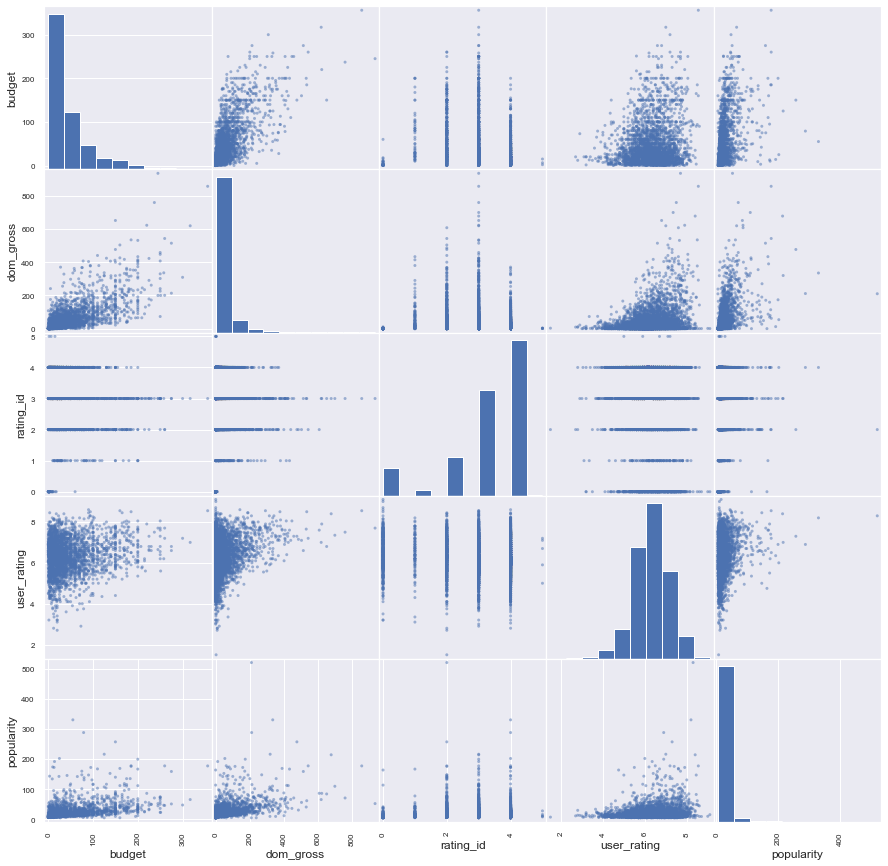

In [132]:
pd.plotting.scatter_matrix(master_movies[['budget', 'dom_gross', 'rating_id', 'user_rating', 'popularity']], figsize=(15, 15));

In [133]:
master_movies.dtypes

title                   object
mpaa_rating             object
rating_id                int64
release_date    datetime64[ns]
genres                  object
studio                  object
franchise               object
is_franchise              bool
popularity             float64
user_rating            float64
total_votes            float64
budget                 float64
dom_gross              float64
world_gross            float64
dom_net                float64
world_net              float64
dtype: object

C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


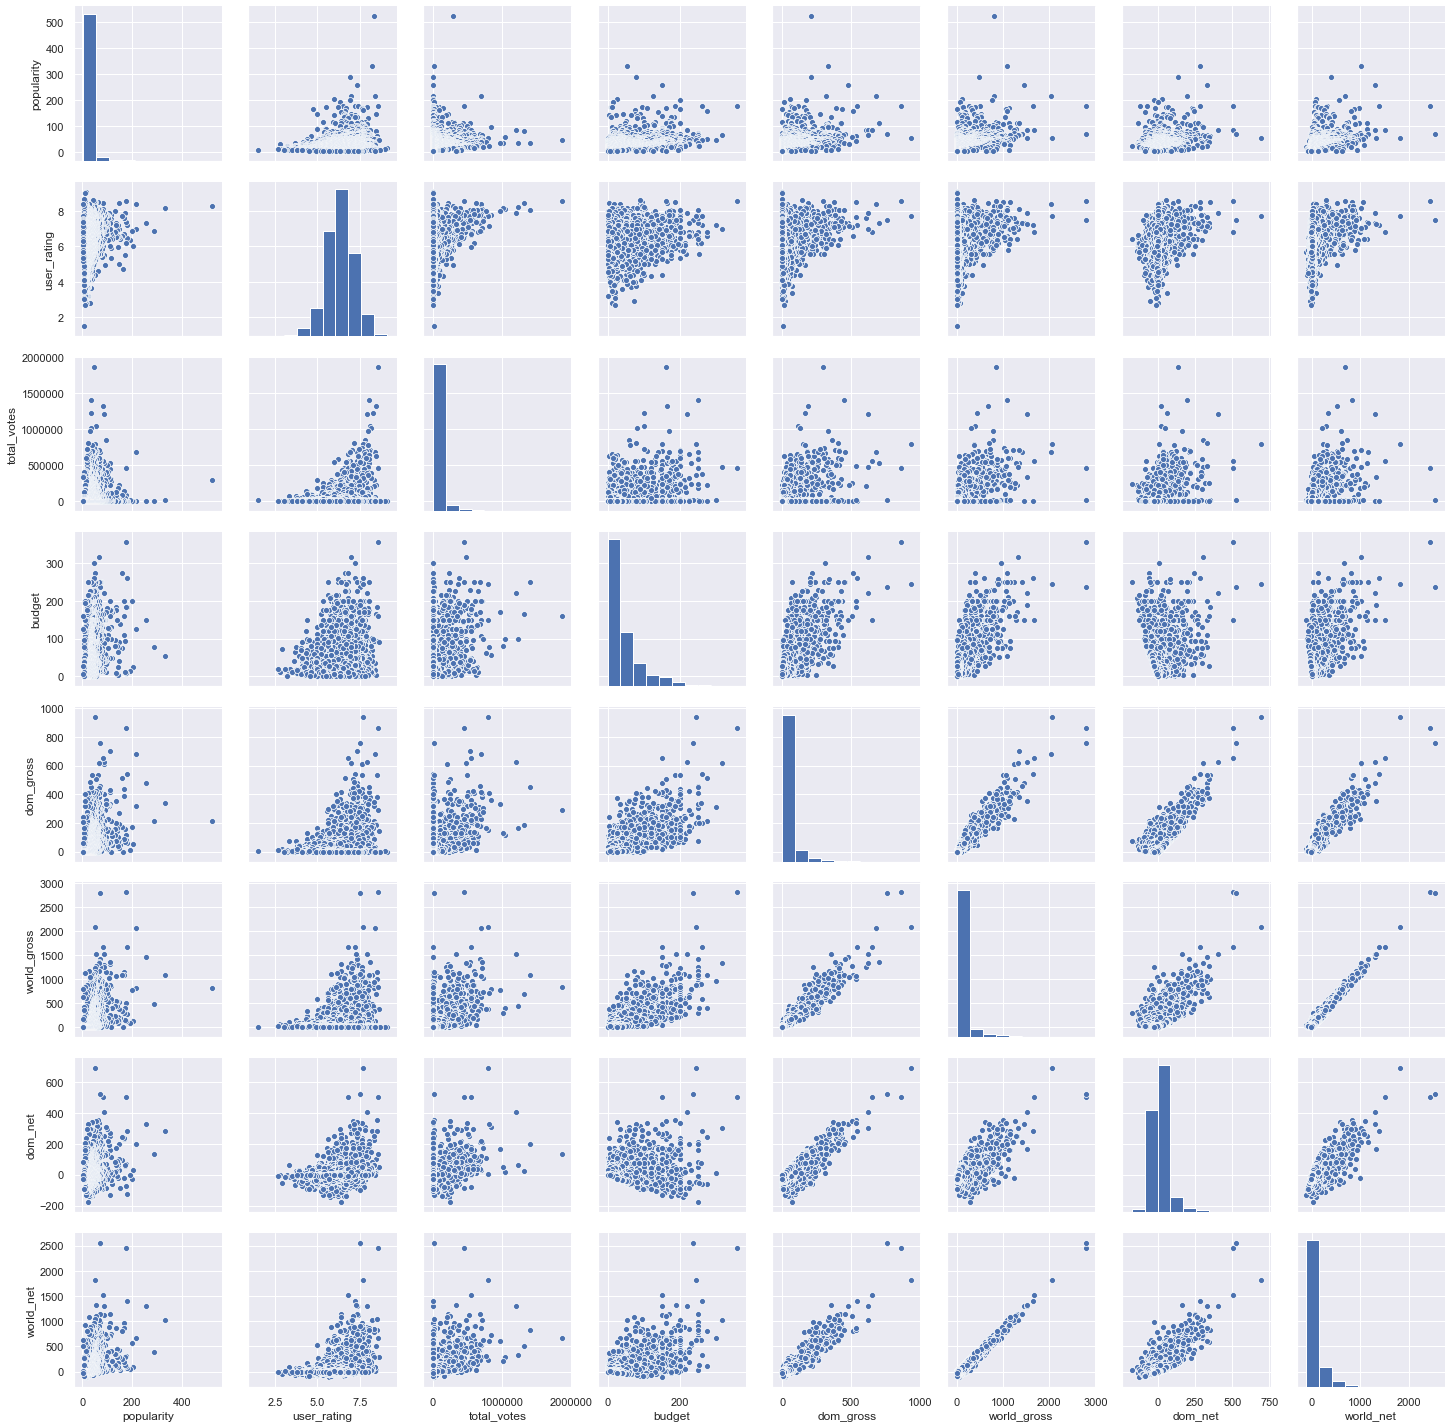

In [134]:
sns.pairplot(master_movies.loc[:,master_movies.dtypes == 'float64']);

,rating_id,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
rating_id,1.000000,-0.023640,0.007612,-0.064183,0.064972,-0.220702,-0.047691,-0.053008,-0.075819,-0.156788
is_franchise,-0.023640,1.000000,0.389477,-0.000011,0.242695,0.324972,0.486688,0.485806,0.349242,0.448934
popularity,0.007612,0.389477,1.000000,0.172082,0.321968,0.425235,0.549576,0.584873,0.353008,0.543117
user_rating,-0.064183,-0.000011,0.172082,1.000000,0.277541,0.157408,0.233219,0.233591,0.314007,0.323655
total_votes,0.064972,0.242695,0.321968,0.277541,1.000000,0.381976,0.517517,0.540178,0.318397,0.468466
budget,-0.220702,0.324972,0.425235,0.157408,0.381976,1.000000,0.692748,0.748745,0.128994,0.622769
dom_gross,-0.047691,0.486688,0.549576,0.233219,0.517517,0.692748,1.000000,0.951350,0.804515,0.933796
world_gross,-0.053008,0.485806,0.584873,0.233591,0.540178,0.748745,0.951350,1.000000,0.681816,0.984919
dom_net,-0.075819,0.349242,0.353008,0.314007,0.318397,0.128994,0.804515,0.681816,1.000000,0.771114
world_net,-0.156788,0.448934,0.543117,0.323655,0.468466,0.622769,0.933796,0.984919,0.771114,1.000000


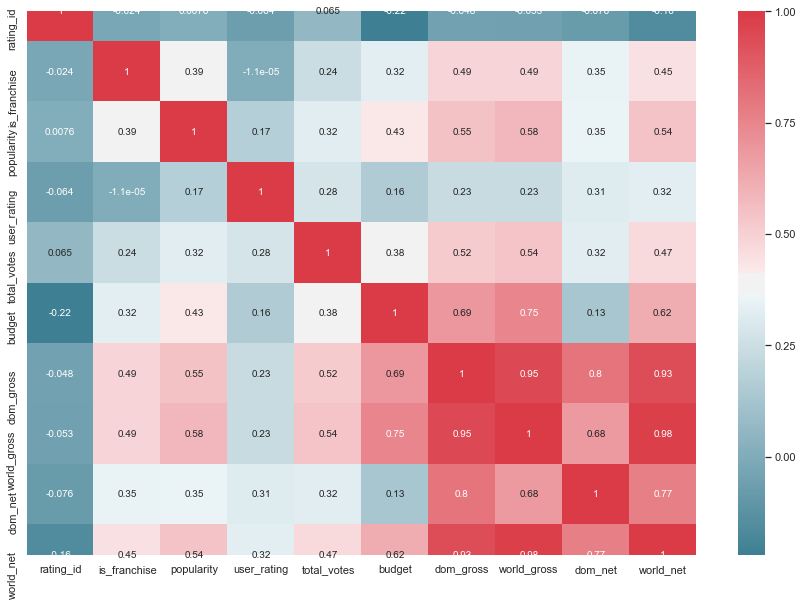

In [135]:
plt.figure(figsize=(15,10))
c= master_movies.corr()
sns.heatmap(c,annot=True, xticklabels=c.columns, yticklabels=c.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))
c

### Correlation Observtions
Observations from scatter plot and heat map

* user rating seems to have no correlation with how well the movie does
* budget has some correlation with gross/net. Which makes sense.
* budget has nearly no correlation with NET. That seems weird.
* a movie's popularity has only minor correlation with gross/net

In [136]:
master_movies.sort_values('dom_gross', ascending=False).head(30)
# top 30 grossing movies, domestic

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
id,,,,,,,,,,,,,,,,
tt2488496,Star Wars The Force Awakens,PG-13,3,2015-12-15,"[28, 12, 878, 14]",Walt Disney Studios Motion Pictures,NaN,True,52.273,7.70,799850.0,245.0,936.662,2068.454,691.662,1823.454
tt4154796,Avengers Endgame,PG-13,3,2019-04-24,"[12, 878, 28]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,177.346,8.55,456667.0,356.0,858.373,2797.801,502.373,2441.801
tt0499549,Avatar,PG-13,3,2009-12-10,"[28, 12, 14, 878]",Twentieth Century Fox,Avatar,True,70.878,7.50,22270.0,237.0,760.508,2790.439,523.508,2553.439
tt1825683,Black Panther,PG-13,3,2018-02-13,"[28, 12, 14, 878]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,109.772,7.35,532388.0,NaN,700.427,1347.462,NaN,NaN
tt4154756,Avengers Infinity War,PG-13,3,2018-04-25,"[12, 28, 878]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,214.301,8.40,690980.0,NaN,678.815,2048.360,NaN,NaN
tt0369610,Jurassic World,PG-13,3,2015-06-06,"[28, 12, 878, 53]",Universal Pictures,Jurassic Park,True,84.240,6.80,555492.0,150.0,652.271,1670.401,502.271,1520.401
tt0848228,The Avengers,PG-13,3,2012-04-25,"[878, 28, 12]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,86.260,7.90,1207036.0,220.0,623.358,1518.816,403.358,1298.816
tt2527336,Star Wars The Last Jedi,PG-13,3,2017-12-13,"[28, 12, 878]",Walt Disney Studios Motion Pictures,NaN,True,65.624,7.00,474088.0,317.0,620.181,1332.697,303.181,1015.697
tt3606756,Incredibles 2,PG,2,2018-06-14,"[28, 12, 16, 10751]",Walt Disney Studios Motion Pictures,The Incredibles,True,86.453,7.60,212769.0,NaN,608.582,1242.805,NaN,NaN


In [137]:
master_movies.sort_values('dom_net', ascending=False).head(10)

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
id,,,,,,,,,,,,,,,,
tt2488496,Star Wars The Force Awakens,PG-13,3,2015-12-15,"[28, 12, 878, 14]",Walt Disney Studios Motion Pictures,NaN,True,52.273,7.70,799850.0,245.0,936.662,2068.454,691.662,1823.454
tt0499549,Avatar,PG-13,3,2009-12-10,"[28, 12, 14, 878]",Twentieth Century Fox,Avatar,True,70.878,7.50,22270.0,237.0,760.508,2790.439,523.508,2553.439
tt4154796,Avengers Endgame,PG-13,3,2019-04-24,"[12, 878, 28]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,177.346,8.55,456667.0,356.0,858.373,2797.801,502.373,2441.801
tt0369610,Jurassic World,PG-13,3,2015-06-06,"[28, 12, 878, 53]",Universal Pictures,Jurassic Park,True,84.240,6.80,555492.0,150.0,652.271,1670.401,502.271,1520.401
tt0848228,The Avengers,PG-13,3,2012-04-25,"[878, 28, 12]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,86.260,7.90,1207036.0,220.0,623.358,1518.816,403.358,1298.816
tt0468569,The Dark Knight,PG-13,3,2008-07-16,"[18, 28, 80, 53]",Warner Bros.,Batman,True,61.787,8.50,23590.0,185.0,535.234,1005.457,350.234,820.457
tt2771200,Beauty And The Beast,PG,2,2017-03-16,"[10751, 14, 10749]",Walt Disney Studios Motion Pictures,NaN,False,56.161,7.10,251238.0,160.0,504.481,1264.064,344.481,1104.064
tt0335345,The Passion Of The Christ,R,4,2004-02-25,[18],Newmarket Films,NaN,False,38.615,7.30,2652.0,27.5,370.783,617.198,343.283,589.698
tt3748528,Rogue One A Star Wars Story,PG-13,3,2016-12-14,"[28, 12, 878]",Walt Disney Studios Motion Pictures,Star Wars,True,40.837,7.65,490033.0,200.0,532.177,1056.058,332.177,856.058


In [138]:
Q1 = master_movies.quantile(0.25)
Q3 = master_movies.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

rating_id           1.000
is_franchise        0.000
popularity          9.919
user_rating         1.100
total_votes     26933.000
budget             47.000
dom_gross          42.417
world_gross        79.784
dom_net            39.208
world_net         103.023
dtype: float64


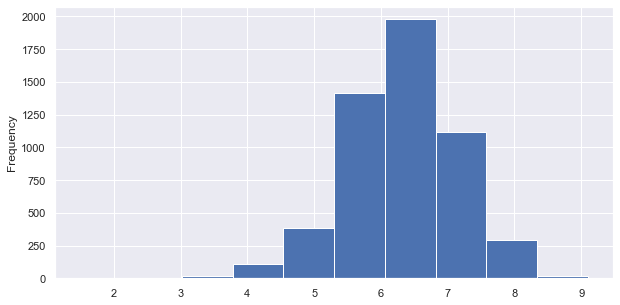

In [139]:
master_movies['user_rating'].plot(kind='hist', figsize=(10,5));

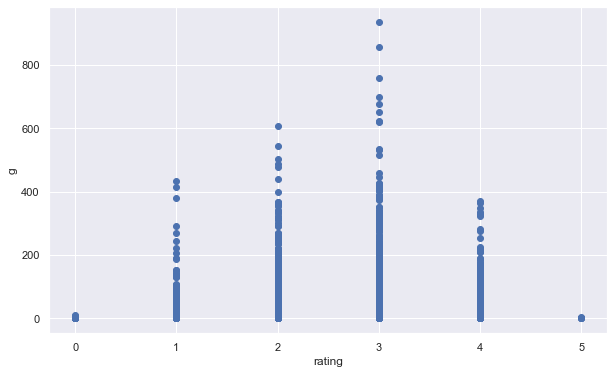

In [140]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(master_movies['rating_id'], master_movies['dom_gross'])
ax.set_xlabel('rating')
ax.set_ylabel('g')
plt.show()

## Franchises

In [141]:
# We'll comparing some full financials, so we use our full_financials data set
franchiseinfo = full_financials.groupby('is_franchise')
franchiseinfo.count()

# 665 franchise films on the list, 2184 non-franchises

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
is_franchise,,,,,,,,,,,,,,,
False,2184,2184,2184,2184,2184,2145,0,2184,2184,2184,2184,2184,2184,2184,2184
True,665,665,665,665,665,663,654,665,665,665,665,665,665,665,665


In [142]:
franchiseinfo.mean()

,rating_id,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
is_franchise,,,,,,,,,
False,3.234432,19.171103,6.309158,48272.175366,37.369747,40.784058,83.831637,3.414310,46.461890
True,3.036090,39.472552,6.347895,108718.288722,74.481668,126.324414,317.364180,51.842746,242.882513


Important things from the mean info:

* While franchises are twice as popular as non-franchises, the average user ratings are nearly identical.
* The budgets of franchise films roughly double, on average, the budgets of non-franchise films
* the worldwide net income of franchise roughly quintuples the worldwide net of non-franchise films, on average

It's important to note that these are averages and include massively popular outliers. Star Wars, Harry Potter, Marvel Cinematic Universe - all of these mega-franchises pull up the entire franchise category as a whole. Let's take a look at our budget and net income spreads without these outliers. 

In [223]:
#histogram showing the world net of franchise films
# x-axis is net
# y-axis is count
isfranchise = full_financials.loc[full_financials['is_franchise'] == True]
isfranchise.head()

sns.histplot(data=isfranchise, x="world_gross", bins=30)



AttributeError: module 'seaborn' has no attribute 'histplot'

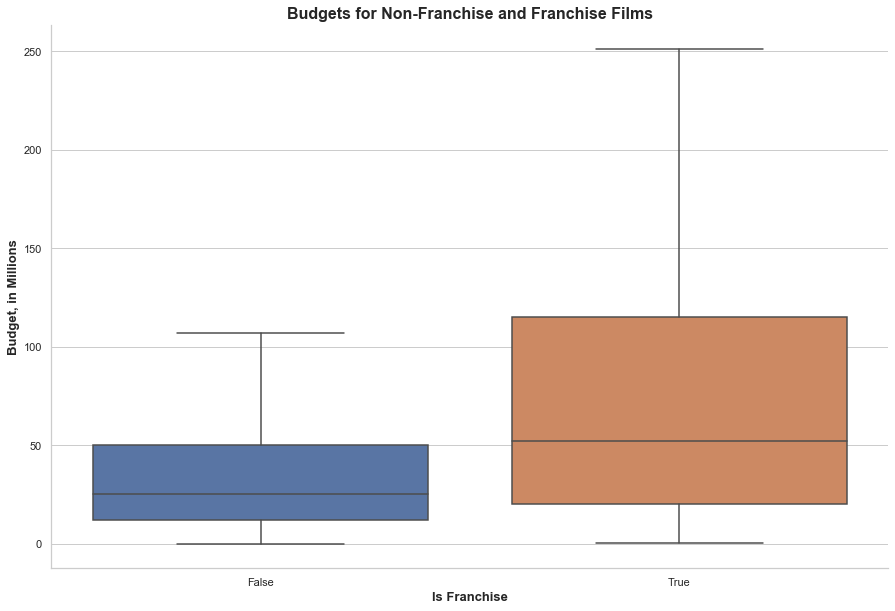

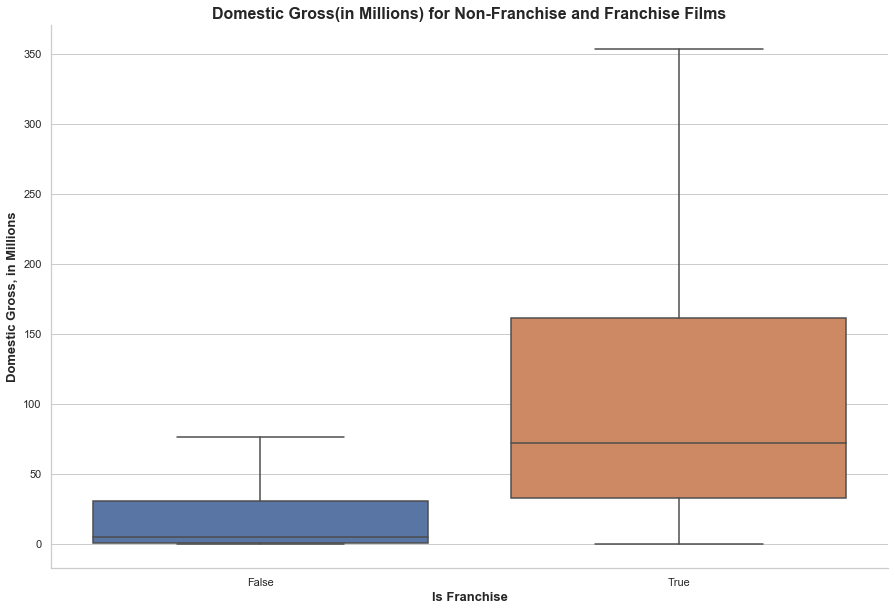

In [206]:
fig, ax=plt.subplots(figsize=(15,10))
data = full_financials
budgets = sns.boxplot(x='is_franchise', y='budget', data=full_financials, showfliers=False)
budgets.set_ylabel('Budget, in Millions',weight='bold',fontsize=13)
budgets.set_xlabel('Is Franchise', weight='bold',fontsize=13)
budgets.set_title('Budgets for Non-Franchise and Franchise Films',weight='bold',fontsize=16)
sns.despine()

fig, ax=plt.subplots(figsize=(15,10))
data = master_movies
budgets = sns.boxplot(x='is_franchise', y='dom_gross', data=master_movies, showfliers=False)
budgets.set_ylabel('Domestic Gross, in Millions',weight='bold',fontsize=13)
budgets.set_xlabel('Is Franchise', weight='bold',fontsize=13)
budgets.set_title('Domestic Gross(in Millions) for Non-Franchise and Franchise Films',weight='bold',fontsize=16)
sns.despine();

On average - franchise films are more popular than non-franchise. Non-franchise also gross and net significantly less on average, but on the flip side, they cost less to make.
User rating of franchise and non franchise films is nearly equal, however franchise films are more popular.

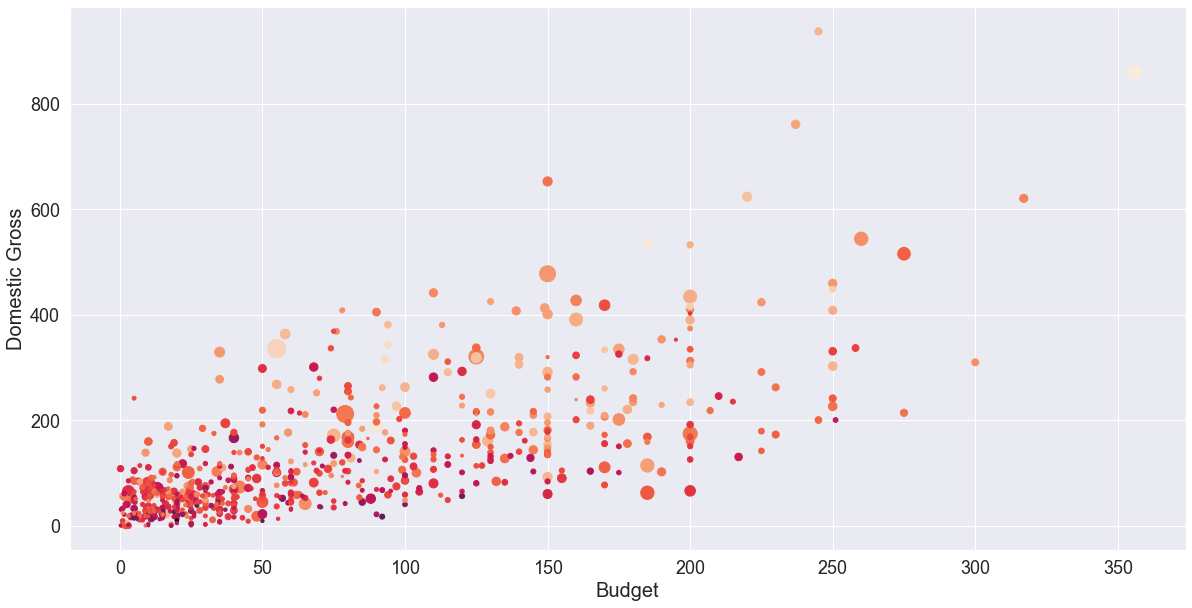

In [148]:
x = isfranchises['budget'].values
y = isfranchises['dom_gross'].values
z = isfranchises['popularity'].values
a = isfranchises['user_rating'].values


# Change the default figure size
plt.figure(figsize=(20,10))

# Add x and y lables, and set their font size
plt.xlabel("Budget", fontsize=20)
plt.ylabel("Domestic Gross", fontsize=20)

# Set the font size of the number lables on the axes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.scatter(x, y, c=a, s=z)
plt.show();

## User Ratings

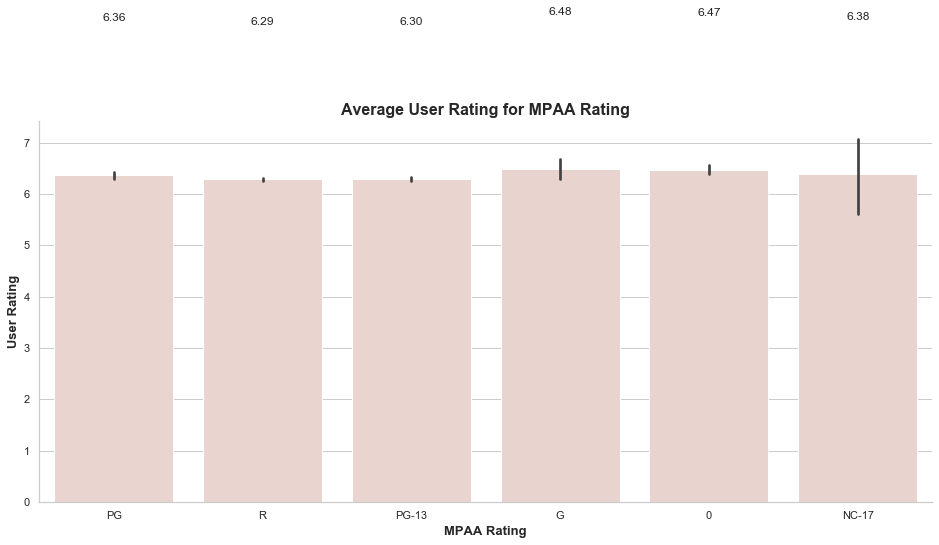

In [197]:
#Vertical Barchart
#Create subplot
sns.set_style('whitegrid') #set theme
fig,ax=plt.subplots(figsize=(16,7))
#Create barplot
user_chart = sns.barplot(x=master_movies['mpaa_rating'],y=master_movies['user_rating'], palette=sns.cubehelix_palette(len(x)))
#Customize chart
user_chart.set_ylabel('User Rating',weight='bold',fontsize=13)
user_chart.set_xlabel('MPAA Rating', weight='bold',fontsize=13)
user_chart.set_title('Average User Rating for MPAA Rating',weight='bold',fontsize=16)
sns.despine()
#Value number on chart
for p in ax.patches: 
    height =p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
        height + 3,
        '{:1.2f}'.format(height),
        ha="center", fontsize=12)

## MPAA Rating

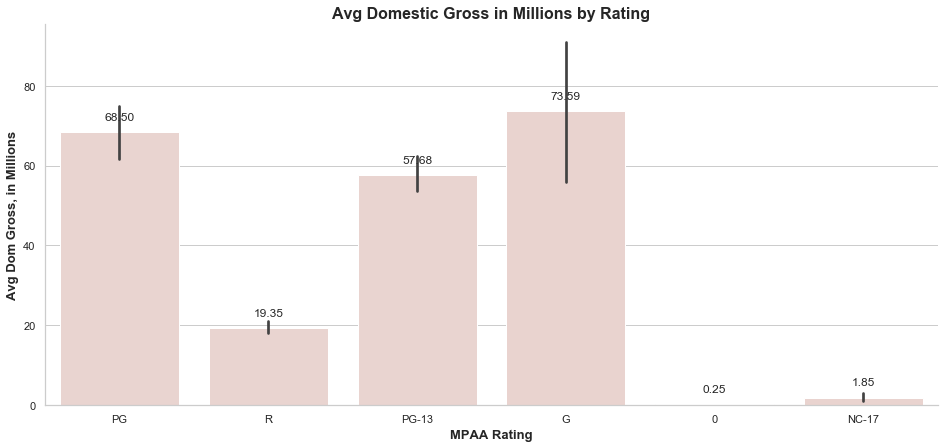

In [195]:
#Vertical Barchart
#Create subplot
sns.set_style('whitegrid') #set theme
fig,ax=plt.subplots(figsize=(16,7))
#Create barplot
mpaa_chart = sns.barplot(x=master_movies['mpaa_rating'],y=master_movies['dom_gross'], palette=sns.cubehelix_palette(len(x)))
#Customize chart
mpaa_chart.set_ylabel('Avg Dom Gross, in Millions',weight='bold',fontsize=13)
mpaa_chart.set_xlabel('MPAA Rating', weight='bold',fontsize=13)
mpaa_chart.set_title('Avg Domestic Gross in Millions by Rating',weight='bold',fontsize=16)
sns.despine()
#Value number on chart
for p in ax.patches: 
    height =p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
        height + 3,
        '{:1.2f}'.format(height),
        ha="center", fontsize=12)

## Studios

In [150]:
master_movies.groupby('studio').mean().sort_values('dom_gross', ascending=False)
# sorting by average dom_gross, we see our top performing studios which produce the biggest blockbusters on average

# 344 studios made our 6749 movies

,rating_id,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
studio,,,,,,,,,,
Walt Disney Studios Motion Pictures,2.319066,0.291829,33.282471,6.633463,95633.085603,93.262631,130.791432,314.858735,44.255897,240.933384
DreamWorks,2.846154,0.282051,23.090667,6.485897,57799.410256,102.227273,121.314564,302.963308,30.705424,234.707515
Sony Pictures Entertainment (SPE),3.119149,0.297872,28.181996,6.239149,67805.110638,65.939767,77.946877,184.324026,16.344060,127.779153
Warner Bros.,3.213592,0.257282,27.883289,6.389320,85009.759709,65.047024,75.062279,177.792541,14.172946,118.259042
Universal Pictures,3.260450,0.315113,27.112723,6.306913,66113.302251,54.950436,74.524820,173.801151,23.595192,127.878672
...,...,...,...,...,...,...,...,...,...,...
Mitropoulos Films,0.000000,0.000000,9.708000,6.500000,181.000000,NaN,0.002000,0.083000,NaN,NaN
FilmBuff,0.000000,0.000000,11.338000,4.700000,1188.000000,NaN,0.001000,0.024000,NaN,NaN
Keystone Entertainment Inc.,4.000000,0.000000,6.492000,6.000000,35.000000,NaN,0.001000,0.001000,NaN,NaN


In [151]:
master_movies.groupby('studio').sum().sort_values('world_gross', ascending=False).head(10)
# sorting on world gross as a sum, we see which studios bring in the most overall gross

,rating_id,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
studio,,,,,,,,,,
Walt Disney Studios Motion Pictures,596,75,8553.595,1704.80,24577703.0,18932.314,33613.398,80918.695,8983.947,48909.477
Warner Bros.,1324,106,11487.915,2632.40,35024021.0,21855.800,30925.659,73250.527,4762.110,39735.038
Twentieth Century Fox,852,85,8152.973,1828.45,20931413.0,15360.950,21207.852,54657.834,4711.063,36574.827
Universal Pictures,1014,98,8432.057,1961.45,20561237.0,15770.775,23177.219,54052.158,6771.820,36701.179
Sony Pictures Entertainment (SPE),733,70,6622.769,1466.20,15934201.0,14177.050,18317.516,43316.146,3513.973,27472.518
Paramount Pictures,698,59,5346.932,1358.20,18024484.0,11996.932,15011.913,32679.829,2568.969,19590.579
Lionsgate,949,67,5907.507,1732.00,15070633.0,5196.302,9279.515,19180.400,2285.835,9974.364
DreamWorks,111,11,900.536,252.95,2254177.0,3373.500,4731.268,11815.569,1013.279,7745.348
New Line Cinema,286,21,1702.284,531.40,141190.0,2679.250,4334.098,8578.265,1280.168,5229.439


In [152]:
full_financials.groupby('studio').mean().sort_values('dom_net', ascending=False).head(10)
# sorting on domestic net on average, we get some interesting results. Our big flashy studios are still there,
# but there are some smaller studios that have a very respectable domestic net income per film
# Pantelion films spent $12mil on a single film that ultimately netted $38mil domestic, which is only about $7mil less
# than the average Disney film nets domestically. Now, the WORLDWIDE net differs greatly ($79mil vs Disney's $260mil),
# but overall we can understand that we can get respectable results on a smaller budget if we do it right

,rating_id,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
studio,,,,,,,,,,
Walt Disney Studios Motion Pictures,2.384236,0.310345,32.343665,6.659852,103306.369458,93.262631,137.518527,334.196015,44.255897,240.933384
Pantelion Films,3.000000,0.000000,35.810000,6.250000,26525.000000,12.000000,50.316000,91.245000,38.316000,79.245000
Newmarket Films,3.750000,0.000000,18.527375,7.200000,15902.375000,19.218750,57.112000,103.916125,37.893250,84.697375
United Artists Releasing,3.250000,0.500000,62.209250,6.450000,7368.500000,15.250000,47.006000,92.192500,31.756000,76.942500
DreamWorks,2.757576,0.333333,24.194152,6.513636,68103.000000,102.227273,132.932697,336.934788,30.705424,234.707515
Summit Entertainment,2.958333,0.250000,27.516375,6.241667,89435.875000,37.145833,67.533375,159.839375,30.387542,122.693542
Universal Pictures,3.250871,0.324042,28.145174,6.301394,68771.616725,54.950436,78.545627,182.829108,23.595192,127.878672
TriStar Pictures,3.000000,0.090909,21.853500,6.595455,101956.500000,26.081818,48.172682,90.800773,22.090864,64.718955
DreamWorks Distribution,3.000000,0.142857,20.930500,6.661905,2467.190476,50.611905,71.351071,144.593905,20.739167,93.982000


In [153]:
master_movies['studio'].value_counts()

Warner Bros.                           412
Universal Pictures                     311
Twentieth Century Fox                  295
Lionsgate                              276
Walt Disney Studios Motion Pictures    257
                                      ... 
Red Envelope Entertainment               1
Paladin Films/Unison Films               1
AMBI Distribution                        1
First Stripe Productions                 1
Innovation Film Group (IFG)              1
Name: studio, Length: 335, dtype: int64

## Studying some cast and crew info

In [154]:
cast_crew.columns

Index(['index', 'title', 'mpaa_rating', 'rating_id', 'release_date', 'genres',
       'studio', 'franchise', 'is_franchise', 'popularity', 'user_rating',
       'total_votes', 'budget', 'dom_gross', 'world_gross', 'dom_net',
       'world_net', 'nconst', 'category', 'primary_name'],
      dtype='object')

In [155]:
cast_crew['category'].unique()
#What kinds of categories are tracked?

array([nan, 'actress', 'writer', 'actor', 'producer', 'director',
       'composer', 'cinematographer', 'editor', 'production_designer',
       'self', 'archive_footage'], dtype=object)

## Director

In [156]:
# make a new series based on the director of the movie
director = cast_crew[cast_crew['category'] == 'director']

In [157]:
# checking out our mean values for this group
director.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 1577 different directors for our movies

,rating_id,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
primary_name,,,,,,,,,,
Joss Whedon,3.0,0.666667,55.276667,7.4500,634991.333333,235.0,362.231,975.655667,306.182,1225.81300
Chris Buck,2.0,1.000000,172.424500,7.3500,267916.500000,150.0,439.056,1365.415000,289.056,1215.41500
Jennifer Lee,2.0,1.000000,172.424500,7.3500,267916.500000,150.0,439.056,1365.415000,289.056,1215.41500
Patty Jenkins,3.0,1.000000,72.788000,7.4000,502894.000000,149.0,412.563,821.847000,263.563,672.84700
J.J. Abrams,3.0,0.750000,64.030250,7.1625,395942.000000,190.0,451.912,967.514750,261.912,777.51475
...,...,...,...,...,...,...,...,...,...,...
Zachary Heinzerling,4.0,0.000000,9.147000,7.1500,4364.000000,NaN,0.200,0.200000,NaN,NaN
Zara Hayes,3.0,0.000000,17.017000,5.8500,828.000000,NaN,13.631,16.418000,NaN,NaN
Zeresenay Mehari,0.0,0.000000,6.460000,6.5000,1157.000000,NaN,0.050,0.097000,NaN,NaN


In [158]:
# Checking how many movies each director has directed.
director.groupby(['primary_name']).count().value_counts('title')
#1015 of our directors have directed only one movie

title
1    1308
2     336
3     168
4      60
5      31
6      11
7       6
8       2
dtype: int64

In [159]:
# select directors that have directed at least 2 movies, so that we know they are proven
#director = director[director.duplicated(subset='primary_name', keep=False)]

# checking out our mean values for this group
director.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 562 repeat directors

,rating_id,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
primary_name,,,,,,,,,,
Joss Whedon,3.0,0.666667,55.276667,7.4500,634991.333333,235.0,362.231,975.655667,306.182,1225.81300
Chris Buck,2.0,1.000000,172.424500,7.3500,267916.500000,150.0,439.056,1365.415000,289.056,1215.41500
Jennifer Lee,2.0,1.000000,172.424500,7.3500,267916.500000,150.0,439.056,1365.415000,289.056,1215.41500
Patty Jenkins,3.0,1.000000,72.788000,7.4000,502894.000000,149.0,412.563,821.847000,263.563,672.84700
J.J. Abrams,3.0,0.750000,64.030250,7.1625,395942.000000,190.0,451.912,967.514750,261.912,777.51475
...,...,...,...,...,...,...,...,...,...,...
Zachary Heinzerling,4.0,0.000000,9.147000,7.1500,4364.000000,NaN,0.200,0.200000,NaN,NaN
Zara Hayes,3.0,0.000000,17.017000,5.8500,828.000000,NaN,13.631,16.418000,NaN,NaN
Zeresenay Mehari,0.0,0.000000,6.460000,6.5000,1157.000000,NaN,0.050,0.097000,NaN,NaN


In [160]:
# Looking at the mean domestic gross of our top 30 directors
directortop30 = director.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
directortop30

primary_name
Joe Russo               551.259750
Anthony Russo           551.259750
Angus MacLane           486.296000
J.J. Abrams             451.912000
Chris Buck              439.056000
Jennifer Lee            439.056000
Josh Cooley             434.038000
Patty Jenkins           412.563000
Joss Whedon             362.231000
Pete Docter             356.922000
Ronnie Del Carmen       356.922000
Jared Bush              341.268000
Jon Favreau             330.078250
Yarrow Cheney           319.502500
Lee Unkrich             312.732500
Brad Bird               303.805333
David Slade             300.532000
Pierre Coffin           294.734333
Rian Johnson            284.010000
Andrew Stanton          279.687000
Christopher Nolan       279.618750
Ryan Coogler            275.432000
Alfonso Cuarón          274.093000
Chris Renaud            272.173400
Kyle Balda              271.566667
Byron Howard            271.045000
Scott Mosier            270.621000
Garth Jennings          270.395000
Christo

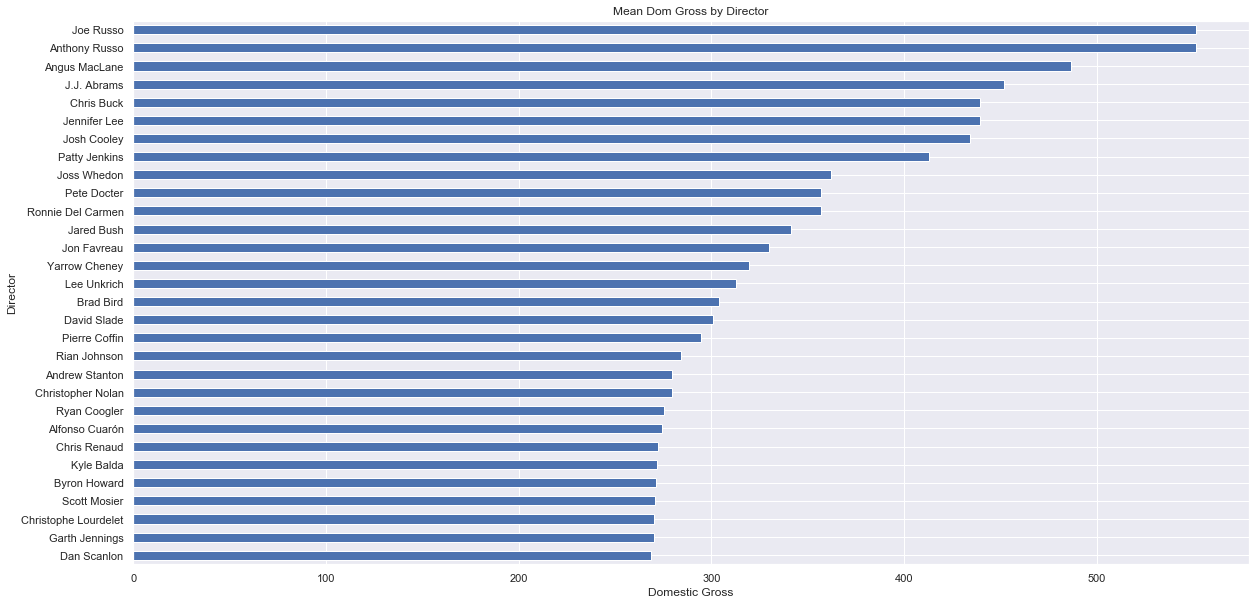

In [161]:
# Bar graph of the domestic gross of our top 30 directors
graphit = directortop30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Mean Dom Gross by Director')
plt.xlabel('Domestic Gross')
plt.ylabel('Director')
graphit.plot();

## Actor

In [162]:
# checking out the actors in our top 30 grossing movies
actor = cast_crew[cast_crew['category'] == 'actor']
actor30 = actor.groupby(['primary_name'])['dom_gross'].max().sort_values(ascending=False).nlargest(30)
actor30

primary_name
Oscar Isaac          936.662
Domhnall Gleeson     936.662
John Boyega          936.662
Robert Downey Jr.    858.373
Mark Ruffalo         858.373
Chris Evans          858.373
Chris Hemsworth      858.373
Chadwick Boseman     700.427
Michael B. Jordan    700.427
Chris Pratt          652.271
Ty Simpkins          652.271
Jeremy Renner        623.358
Mark Hamill          620.181
Craig T. Nelson      608.582
Huck Milner          608.582
Chiwetel Ejiofor     543.638
James Earl Jones     543.638
Donald Glover        543.638
Seth Rogen           543.638
Donnie Yen           532.177
Alan Tudyk           532.177
Diego Luna           532.177
Adam Driver          515.203
Josh Gad             504.481
Dan Stevens          504.481
Luke Evans           504.481
Ed O'Neill           486.296
Albert Brooks        486.296
Jonathan Groff       477.374
Sterling K. Brown    477.374
Name: dom_gross, dtype: float64

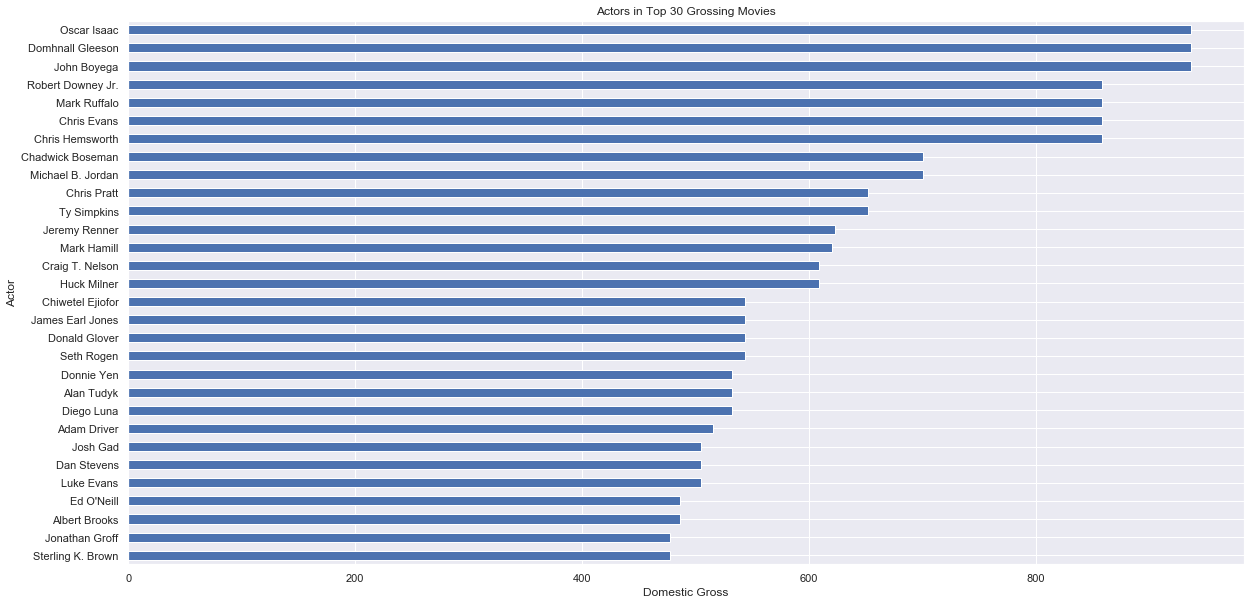

In [163]:
# Your code here
graphit = actor30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Actors in Top 30 Grossing Movies')
plt.xlabel('Domestic Gross')
plt.ylabel('Actor')
graphit.plot();

In [164]:
# Looking at the mean domestic gross of the actors
actormean = actor.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
actormean

primary_name
Huck Milner          608.582000
Craig T. Nelson      608.582000
Ed O'Neill           486.296000
Donald Glover        378.703000
Robert Downey Jr.    370.767833
Neel Sethi           364.001000
Marwan Kenzari       355.559000
Mena Massoud         355.559000
Ty Simpkins          353.140000
Cole Konis           350.126000
Pierre Coffin        336.046000
Finn Wolfhard        328.829000
Jonathan Groff       292.722333
Donnie Yen           288.537500
John Boyega          275.838333
James Earl Jones     272.499000
Pharrell Williams    270.621000
Bill Skarsgård       270.211000
Alan Tudyk           266.200500
Trey Parker          264.624000
Chris Evans          263.849929
Ken Stott            258.367000
Temuera Morrison     248.757000
Mike Myers           238.737000
Jordan Peele         227.315000
Benjamin Bratt       223.249000
Scott Adsit          222.528000
Gwilym Lee           216.668000
Ben Hardy            216.668000
David Schwimmer      216.391000
Name: dom_gross, dtype: flo

## Actress

In [165]:
# checking out the actresses in our top 30 grossing movies
actress = cast_crew[cast_crew['category'] == 'actress']
actress30 = actress.groupby(['primary_name'])['dom_gross'].max().sort_values(ascending=False).nlargest(30)
actress30

primary_name
Daisy Ridley           936.662
Danai Gurira           700.427
Lupita Nyong'o         700.427
Bryce Dallas Howard    652.271
Judy Greer             652.271
Scarlett Johansson     623.358
Sarah Vowell           608.582
Holly Hunter           608.582
Felicity Jones         532.177
Billie Lourd           515.203
Emma Watson            504.481
Ellen DeGeneres        486.296
Kaitlin Olson          486.296
Kristen Bell           477.374
Evan Rachel Wood       477.374
Anne Hathaway          448.139
Christina Hendricks    434.038
Brie Larson            426.830
Jennifer Lawrence      424.668
Joan Cusack            415.005
Gal Gadot              412.563
Robin Wright           412.563
Lucy Davis             412.563
Gwyneth Paltrow        409.014
Karen Gillan           404.540
Idina Menzel           400.738
Zendaya                390.532
Angourie Rice          390.532
Zoe Saldana            389.813
Lake Bell              368.384
Name: dom_gross, dtype: float64

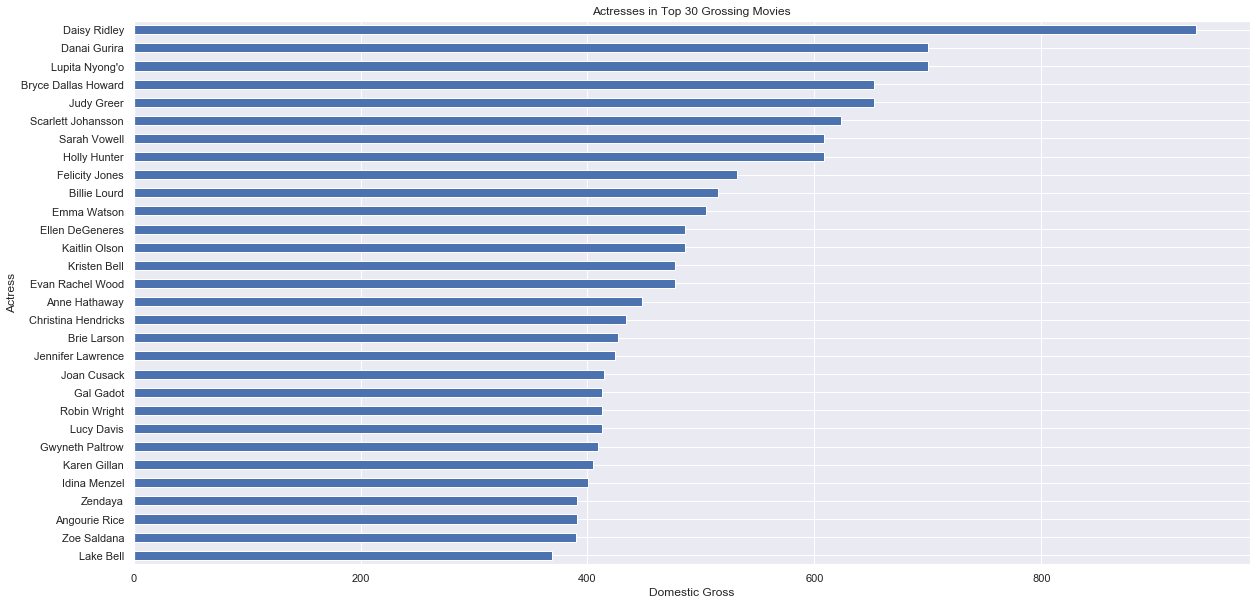

In [166]:
# Your code here
graphit = actress30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Actresses in Top 30 Grossing Movies')
plt.xlabel('Domestic Gross')
plt.ylabel('Actress')
graphit.plot();

## Writer

In [167]:
# make a new series based on the writer of the movie
writer = cast_crew[cast_crew['category'] == 'writer']

In [168]:
# checking out our mean values for this group
writer.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 3983 different writers for our list of 6729 movies

,rating_id,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
primary_name,,,,,,,,,,
Stephen Chbosky,2.000000,0.000000,56.161,7.100000,251238.000000,160.0,504.481000,1264.064000,344.4810,1104.0640
John Knoll,3.000000,1.000000,40.837,7.650000,490033.000000,200.0,532.177000,1056.058000,332.1770,856.0580
Lawrence Kasdan,3.000000,1.000000,51.670,7.250000,515904.500000,260.0,575.215000,1230.689500,315.2150,970.6895
Chris Van Allsburg,3.000000,1.000000,60.168,6.900000,252638.000000,90.0,404.540000,962.102000,314.5400,872.1020
George Lucas,2.833333,0.833333,64.465,7.008333,335217.166667,262.4,471.736833,989.646833,301.1982,922.4556
...,...,...,...,...,...,...,...,...,...,...
Zach Dean,4.000000,0.000000,16.012,6.100000,36924.000000,NaN,0.066000,1.946000,NaN,NaN
Zach Smith,3.000000,0.000000,28.688,5.100000,3640.000000,NaN,4.720000,4.874000,NaN,NaN
Zack Kahn,4.000000,0.000000,32.411,6.550000,23201.000000,NaN,0.020000,0.176000,NaN,NaN


In [169]:
# Checking how many movies each writer has written.
writer.groupby(['primary_name']).count().value_counts('title')
# most of our writers have only written one movie!

title
1    2212
2     361
3     154
4      70
5      37
6      19
7       7
8       5
9       3
dtype: int64

In [170]:
# Looking at the mean domestic gross of our top 30 writers
writertop30 = writer.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
writertop30

primary_name
Joe Robert Cole       700.427000
Lawrence Kasdan       575.215000
Brenda Chapman        543.638000
John Knoll            532.177000
Stephen Chbosky       504.481000
Victoria Strouse      486.296000
George Lucas          471.736833
Colin Trevorrow       466.461500
Rashida Jones         434.038000
Valerie LaPointe      434.038000
Andrew Stanton        424.521500
Jim Starlin           424.409500
Allan Heinberg        412.563000
Chris Van Allsburg    404.540000
Shane Morris          400.738000
Steve Gan             389.813000
Steve Englehart       389.813000
Zak Penn              380.524000
Michael Arndt         375.311000
Justin Marks          364.001000
Suzanne Collins       362.884750
Dan Abnett            361.495000
Andy Lanning          361.495000
Josh Cooley           356.922000
Simon Rich            356.922000
Jim DeFelice          350.126000
Scott McEwen          350.126000
Christopher Markus    342.789750
Stephen McFeely       342.789750
Geoff Johns           335.0620

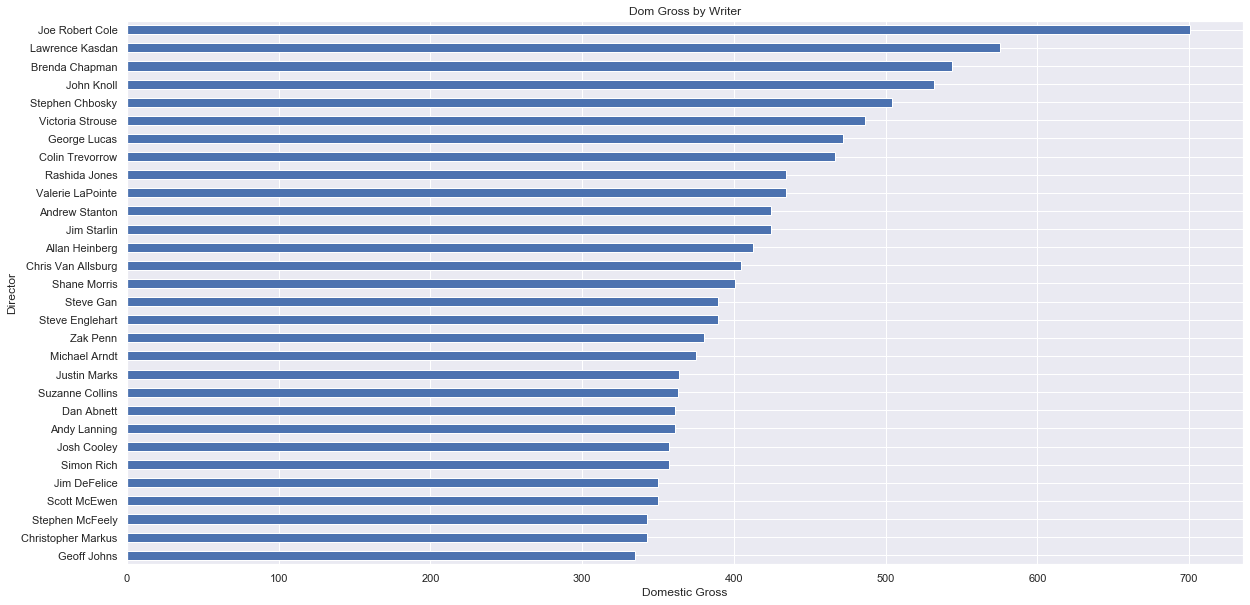

In [171]:
# Bar graph of the domestic gross of our top 30 directors
graphit = writertop30.sort_values().plot(kind='barh', figsize=(20,10))
#deaths = df.groupby(['State'])['Deaths'].sum().sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Dom Gross by Writer')
plt.xlabel('Domestic Gross')
plt.ylabel('Director')
graphit.plot();

In [172]:
master_movies.sort_values('dom_gross', ascending=False).head(50)

,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,user_rating,total_votes,budget,dom_gross,world_gross,dom_net,world_net
id,,,,,,,,,,,,,,,,
tt2488496,Star Wars The Force Awakens,PG-13,3,2015-12-15,"[28, 12, 878, 14]",Walt Disney Studios Motion Pictures,NaN,True,52.273,7.70,799850.0,245.0,936.662,2068.454,691.662,1823.454
tt4154796,Avengers Endgame,PG-13,3,2019-04-24,"[12, 878, 28]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,177.346,8.55,456667.0,356.0,858.373,2797.801,502.373,2441.801
tt0499549,Avatar,PG-13,3,2009-12-10,"[28, 12, 14, 878]",Twentieth Century Fox,Avatar,True,70.878,7.50,22270.0,237.0,760.508,2790.439,523.508,2553.439
tt1825683,Black Panther,PG-13,3,2018-02-13,"[28, 12, 14, 878]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,109.772,7.35,532388.0,NaN,700.427,1347.462,NaN,NaN
tt4154756,Avengers Infinity War,PG-13,3,2018-04-25,"[12, 28, 878]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,214.301,8.40,690980.0,NaN,678.815,2048.360,NaN,NaN
tt0369610,Jurassic World,PG-13,3,2015-06-06,"[28, 12, 878, 53]",Universal Pictures,Jurassic Park,True,84.240,6.80,555492.0,150.0,652.271,1670.401,502.271,1520.401
tt0848228,The Avengers,PG-13,3,2012-04-25,"[878, 28, 12]",Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,True,86.260,7.90,1207036.0,220.0,623.358,1518.816,403.358,1298.816
tt2527336,Star Wars The Last Jedi,PG-13,3,2017-12-13,"[28, 12, 878]",Walt Disney Studios Motion Pictures,NaN,True,65.624,7.00,474088.0,317.0,620.181,1332.697,303.181,1015.697
tt3606756,Incredibles 2,PG,2,2018-06-14,"[28, 12, 16, 10751]",Walt Disney Studios Motion Pictures,The Incredibles,True,86.453,7.60,212769.0,NaN,608.582,1242.805,NaN,NaN


## Writer/Director Teams

Do we have any writing/directing teams 

In [173]:
# make a new series with only the writing and directing personnel categories for the movie
teams = cast_crew[(cast_crew['category'] == 'writer') | (cast_crew['category'] == 'director')]

teams.loc[teams['category'] == 'writer', 'writers'] = teams['nconst']
teams.loc[teams['category'] == 'director', 'directors'] = teams['nconst']

C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [174]:
teams.sort_values('index', ascending=False)

,index,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,...,budget,dom_gross,world_gross,dom_net,world_net,nconst,category,primary_name,writers,directors
30382,tt9896916,The Pilgrims Progress,PG,2,2019-04-18,"[12, 16]",Fathom Events,NaN,False,74.998,...,NaN,1.295,3.173,NaN,NaN,nm10567937,writer,John Bunyan,nm10567937,NaN
30378,tt9896916,The Pilgrims Progress,PG,2,2019-04-18,"[12, 16]",Fathom Events,NaN,False,74.998,...,NaN,1.295,3.173,NaN,NaN,nm9546685,director,Robert Fernandez,NaN,nm9546685
30372,tt9617716,Everybodys Everything,0,0,2019-11-12,[99],Gunpowder & Sky,NaN,False,15.435,...,NaN,0.547,0.749,NaN,NaN,nm5385537,director,Ramez Silyan,NaN,nm5385537
30370,tt9617716,Everybodys Everything,0,0,2019-11-12,[99],Gunpowder & Sky,NaN,False,15.435,...,NaN,0.547,0.749,NaN,NaN,nm3758612,director,Sebastian Jones,NaN,nm3758612
30367,tt9617456,For Sama,0,0,2019-10-09,"[99, 10752]",PBS Distribution,NaN,False,9.663,...,NaN,0.044,1.398,NaN,NaN,nm3117666,director,Edward Watts,NaN,nm3117666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,tt0365907,A Walk Among The Tombstones,R,4,2014-09-18,"[80, 18, 9648, 53]",Universal Pictures,NaN,False,31.463,...,28.0,26.308,58.834,-1.692,30.834,nm0088747,writer,Lawrence Block,nm0088747,NaN
1045,tt0365907,A Walk Among The Tombstones,R,4,2014-09-18,"[80, 18, 9648, 53]",Universal Pictures,NaN,False,31.463,...,28.0,26.308,58.834,-1.692,30.834,nm0291082,director,Scott Frank,NaN,nm0291082
980,tt0359950,The Secret Life Of Walter Mitty,PG,2,2013-12-18,"[12, 35, 18, 14]",Twentieth Century Fox,NaN,False,15.802,...,90.0,58.237,188.133,-31.763,98.133,nm0175726,writer,Steve Conrad,nm0175726,NaN
867,tt0337692,On The Road,R,4,2012-05-22,"[12, 18]",IFC Films,NaN,False,12.685,...,NaN,0.744,9.617,NaN,NaN,nm0758574,director,Walter Salles,NaN,nm0758574


In [175]:
teams.loc[(teams['writers'] == teams['directors'])]
# apparently there are no repeating teams

,index,title,mpaa_rating,rating_id,release_date,genres,studio,franchise,is_franchise,popularity,...,budget,dom_gross,world_gross,dom_net,world_net,nconst,category,primary_name,writers,directors


# TO DO

Reduce numbers for readability - 3.2.2, 3.4.2

Adjust numbers for inflation





Visualizations/stuff to look at:

* gross by release date



* gross/net against studio


* gross/net by MPAA rating
* gross/net by MPAA rating and genre


* scatter with directors vs gross where size is how many movies they have directed


* put budget and gross box plots on same graph for franchise and non franchise


* group by rating 


* How many actors/actresses do franchise films have versus non-franchise? (count of actors/actresses)


* Who are the top actors in franchise films, vs the top actors in non-franchise films?


* study successful franchises by smaller studios (twilight? fifty shades?)
    * see a visualization or list of lowest budget films with at least three franchise entries and check out net

Do all of the functions have docstrings?
Did I follow PEP8?

## Genres

Break out genres, and study numbers vs genre

* check out genres of franchises
    * histogram
    * x-axis is genres
    * y-axis is number of franchise movies in the genre
    

* check out genres of non-franchises
    * histogram
    * x-axis is genres
    * y-axis is number of non-franchise movies in the genre


* gross by genre+franchise status (franchise or not)
    * vertical bar plot
    * side-by-side bars of franchise and not franchise
    * x-axis is genre
    * y-axis is average gross


* net by genre+franchise status (franchise or not)
    * vertical bar plot
    * side-by-side bars of franchise and not franchise
    * x-axis is genre
    * y-axis is average net


* scatter of net by genre+franchises
    * x-axis is budget?
    * y-axis is gross
    * color is franchise/not franhcise
    * regression of franchise/not franchise

## Franchises



Study franchises

Look closer into the net income information to give specific examples of smaller movies that were profitable

* gross/net of franchise vs non-franchise


* user rating vs franchise and non franchise


* risk vs reward on small movies vs franchise
    * normalize data and plot on same figure

# Presentation Notes

* Show risk vs reward of franchise investment vs single film. Show Disney avg net per film vs small studio
* Example - Twilight
* Additional revenues from merchandising
* Minecraft? Perfect intersection of franchise and existing IP that MS already owns?
* opportunities for future work -

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

dataframe = pd.read_csv("scottish_hills.csv")

x = dataframe.Height
y = dataframe.Latitude

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

# Change the default figure size
plt.figure(figsize=(10,10))

# Change the default marker for the scatter from circles to x's
plt.scatter(x, y, marker='x')

# Set the linewidth on the regression line to 3px
plt.plot(x, m * x + b, color="red", linewidth=3)

# Add x and y lables, and set their font size
plt.xlabel("Height (m)", fontsize=20)
plt.ylabel("Latitude", fontsize=20)

# Set the font size of the number lables on the axes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig("python-linear-reg-custom.png")

FileNotFoundError: [Errno 2] No such file or directory: 'scottish_hills.csv'